In [1]:
import pandas as pd
import os
from tqdm.notebook import tqdm
import geopandas as gpd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import AutoMinorLocator,MultipleLocator,FuncFormatter
import copy
from sklearn.linear_model import LinearRegression
import netCDF4
import rioxarray
import xarray as xr
import statsmodels.api as sm
from statsmodels.formula.api import ols
import datetime
from shapely.geometry import mapping

## 1.读取数据

In [2]:
#2000-2019年中国湖泊时序重构数据集
China_Lakes_time_series=pd.read_csv(r'1_data\lake area time series_2000-2019_China.csv').dropna()
China_Lakes_time_series

,GLAKES_ID,Year,Reservoir_flag,Area_raw,Area_dr
0,44,2000,0,151.452703,1211.170476
1,44,2001,0,1030.693554,1210.341072
2,44,2002,0,472.115406,1210.310305
3,44,2003,0,1212.516327,1214.170653
4,44,2004,0,1207.558202,1212.641128
...,...,...,...,...,...
143575,192203,2015,0,0.978261,0.979147
143576,192203,2016,0,0.956111,0.956259
143577,192203,2017,0,0.931747,0.931747
143578,192203,2018,0,0.915504,0.915947


In [ ]:
#GLAKES数据集
GLAKES_China=gpd.read_file(r'1_data\GLAKES_of_China.shp')
GLAKES_China

In [ ]:
#从GLAKES中筛选出研究数据
lake=GLAKES_China.query('Lake_id in {}'.format(China_Lakes_time_series['GLAKES_ID'].unique().tolist()))
lake=lake[lake['Rser_flag']==0]
lake.to_file('interest_lakes.shp', driver='ESRI Shapefile')
lake

In [ ]:
# lake=gpd.read_file('interest_lakes.shp')
# lake

In [3]:
six_region=gpd.read_file(r'1_data\CN_div6_wgs84.shp')
bou_2_4l=gpd.read_file(r'1_data\bou2_4l.shp')
nine_Line=gpd.read_file(r'1_data\九段线.shp')
southern_sea_island=gpd.read_file(r'1_data\南海诸岛及其它岛屿.shp')
six_region

,AREA,name,geometry
0,1631730.0,XJ,"POLYGON ((86.85125 49.10808, 86.85143 49.10839..."
1,789579.0,NE,"MULTIPOLYGON (((121.59513 38.79301, 121.59442 ..."
2,2064510.0,EP,"MULTIPOLYGON (((109.67783 18.18660, 109.67836 ..."
3,1899130.0,TP,"POLYGON ((97.02007 39.20921, 97.02058 39.20905..."
4,1985600.0,MP,"POLYGON ((121.49761 53.32596, 121.50095 53.321..."
5,1127780.0,YG,"POLYGON ((102.91254 34.31357, 102.91420 34.312..."


## 2.绘制地图
https://blog.csdn.net/qq_35240689/article/details/130132703
https://gis.stackexchange.com/questions/388512/adding-custom-names-to-a-geopandas-legend

In [3]:
proj = ccrs.LambertConformal(central_longitude=105, 
                              central_latitude=40,
                              standard_parallels=(25.0, 47.0))
lw=[0.25,0.5,0.8,1,2] #line width (px)
fs=[8,12,14] #font size (px)
plt.rc('font',family='Arial', size=fs[0])
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
colors = {0:'#EEDD82', 1:'#D8BFD8', 2:'#FFB5C5', 3:'#EE6363',4:'#F4A460',5:'#90EE90'}
regions=['EP','MP','XJ','NE','YG','TP']

In [4]:
def add_northern_sea(ax):
    ax.add_geometries(bou_2_4l['geometry'],facecolor='white',edgecolor='black',linewidth=lw[1],crs=ccrs.PlateCarree())
    ax.add_geometries(nine_Line['geometry'],color='black',linewidth=lw[1],crs=ccrs.PlateCarree())
    ax.add_geometries(southern_sea_island['geometry'],facecolor='white',edgecolor='black',linewidth=lw[1],crs=ccrs.PlateCarree())

def draw_label(ax,x,y,text):
    ax.text(x,y,text,transform=ax.transAxes)

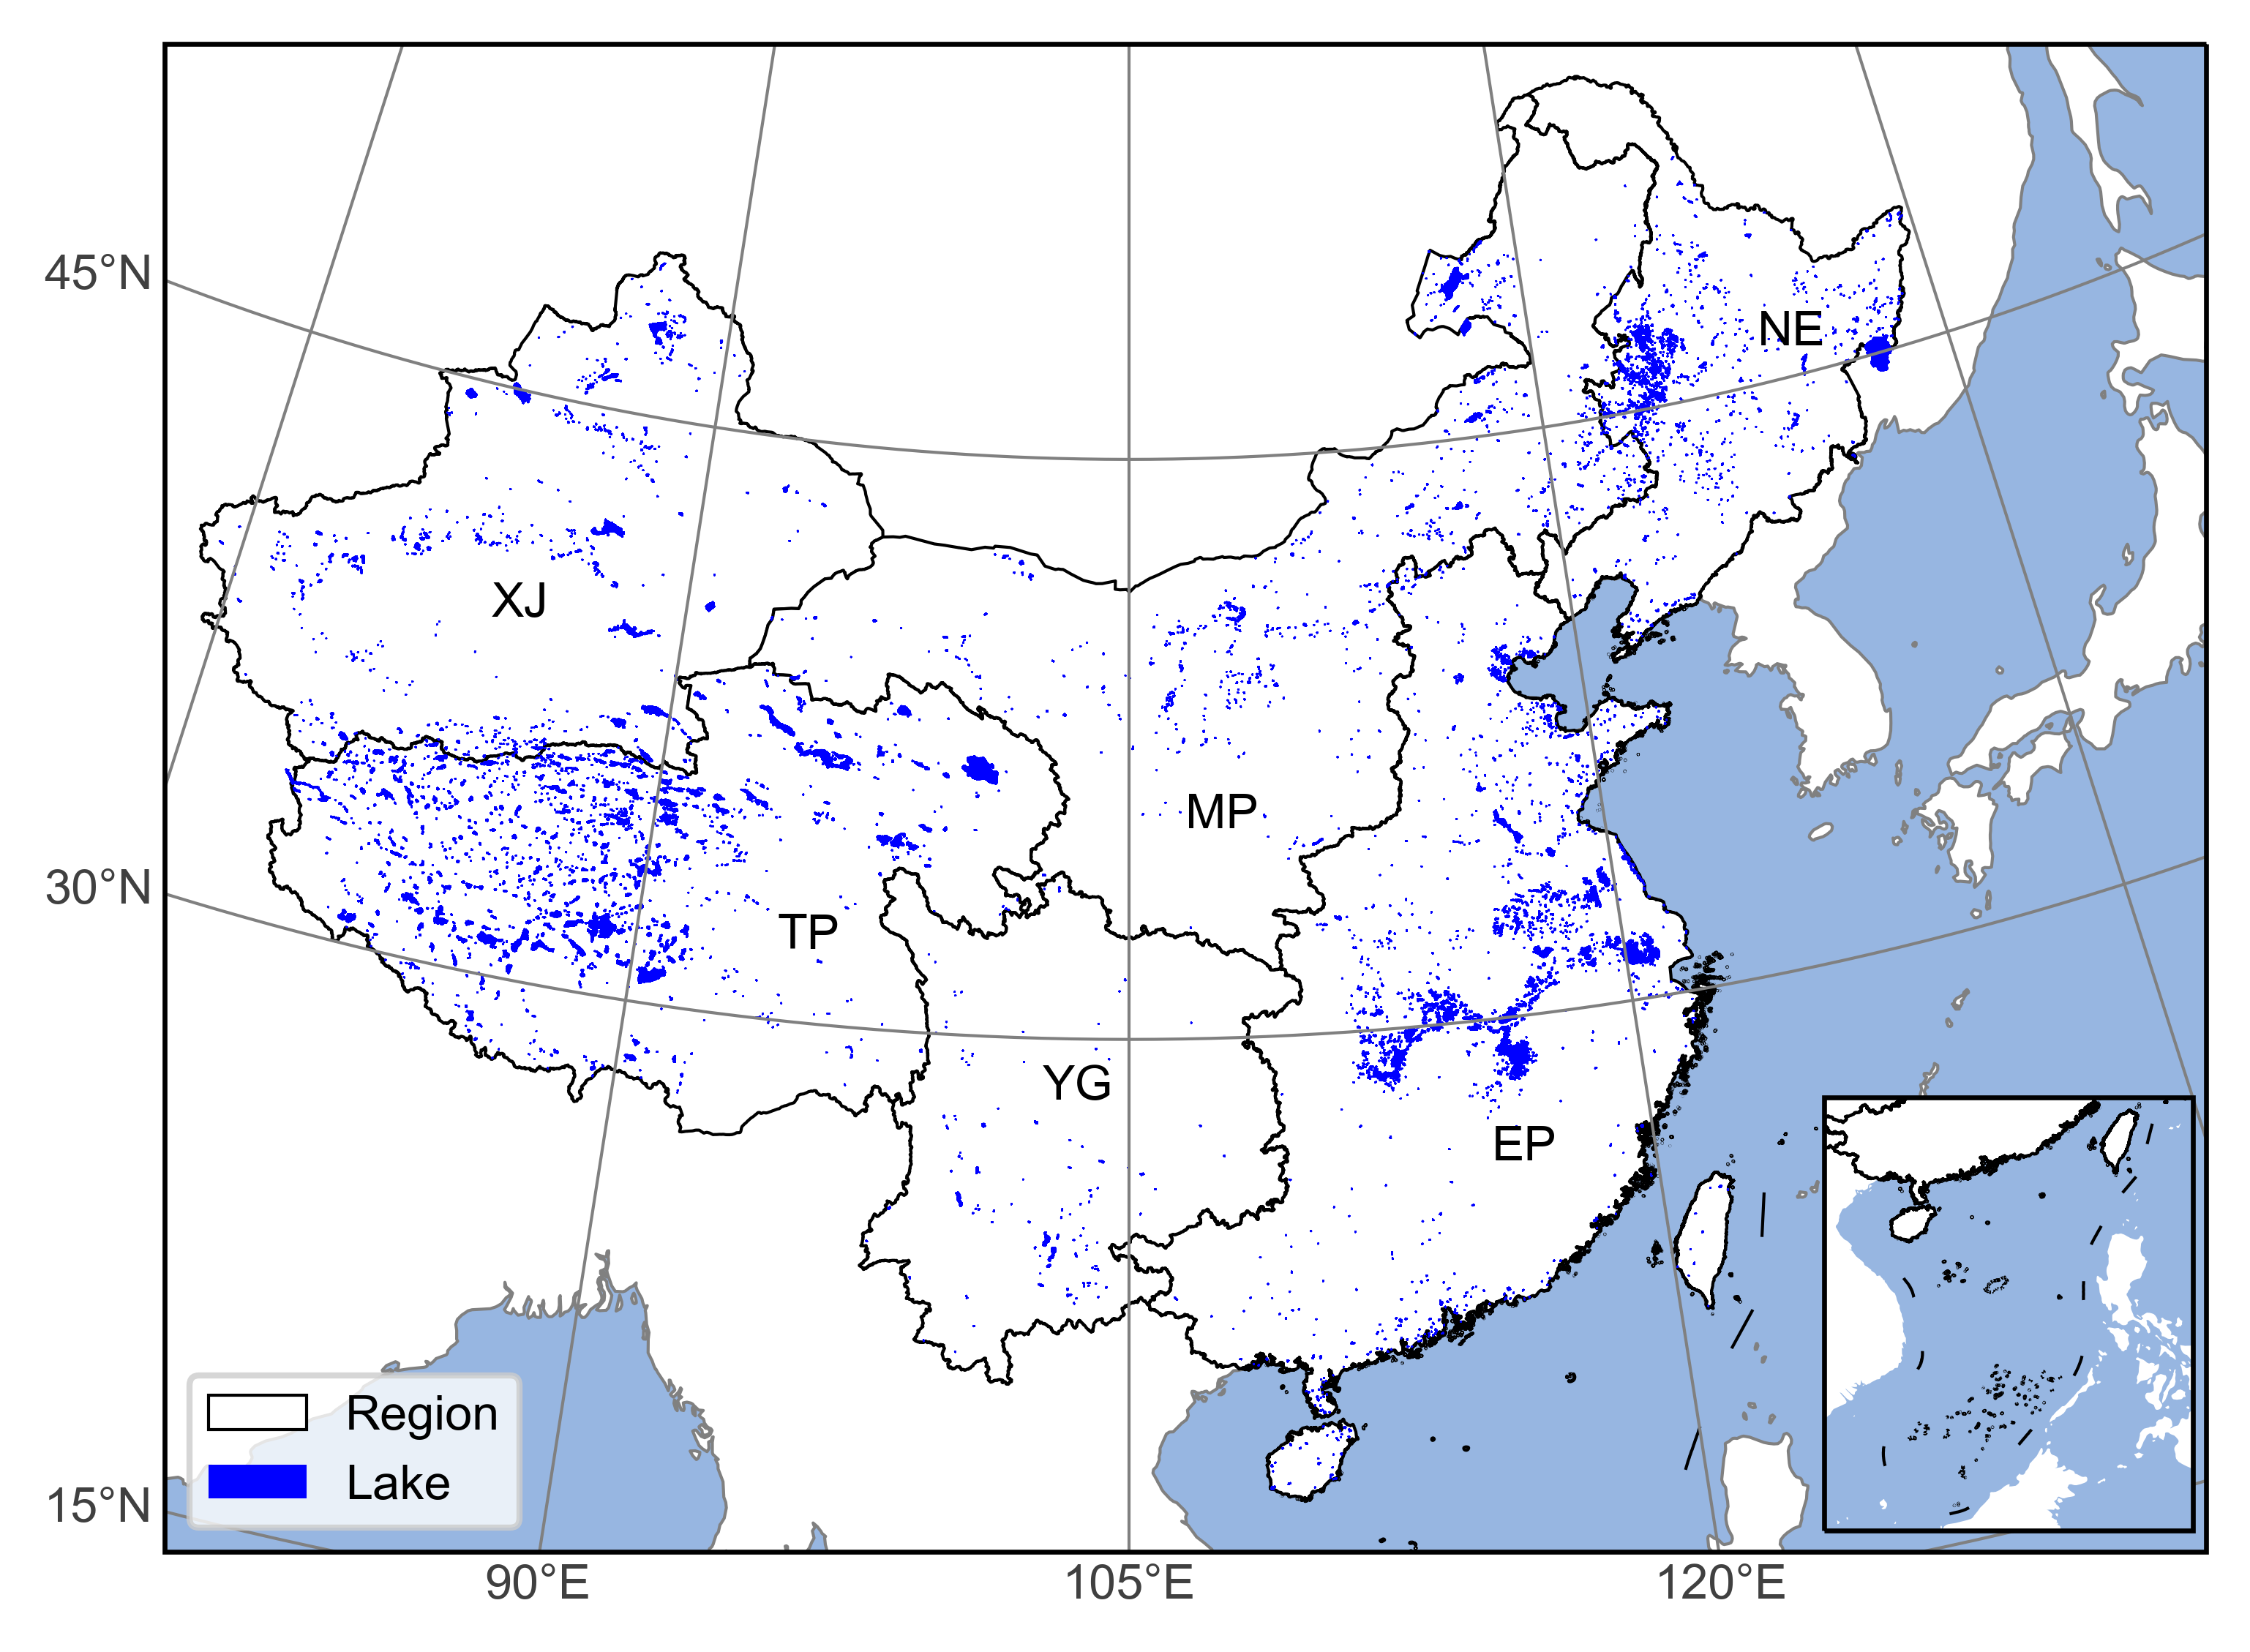

In [11]:
fig = plt.figure(figsize=(6,4.8), dpi=600) #inch
ax=plt.axes(projection=proj)
ax.spines['geo'].set_linewidth(lw[2])
ax.set_extent([80, 133, 17, 53], crs=ccrs.PlateCarree())

#添加地图基本要素
ax.add_feature(cfeature.OCEAN, zorder=0)
ax.add_feature(cfeature.LAND, edgecolor='gray', facecolor='white',linewidth=lw[1], zorder=1)
add_northern_sea(ax)

#添加六大湖区
ax.add_geometries(six_region["geometry"],linewidth=lw[1],crs=ccrs.PlateCarree(),facecolor='w',edgecolor='black')
draw_label(ax,0.3,0.4,'TP')
draw_label(ax,0.43,0.3,'YG')
draw_label(ax,0.65,0.26,'EP')
draw_label(ax,0.5,0.48,'MP')
draw_label(ax,0.78,0.8,'NE')
draw_label(ax,0.16,0.62,'XJ')

#添加研究的湖泊
ax.add_geometries(lake["geometry"],crs=ccrs.PlateCarree(),facecolor='blue',edgecolor='blue',linewidth=lw[0])

#添加图例
pmarks = []
pmarks.append(Patch(facecolor='w', edgecolor='black',label='Region',linewidth=lw[1]))
# pmarks.append(Patch(facecolor='red', label='Reservoir'))
pmarks.append(Patch(facecolor='blue', label='Lake'))
handles, _ = ax.get_legend_handles_labels()
ax.legend(handles=[*handles,*pmarks], loc='lower left')

#设置格网
gls = ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), 
                   color='gray',  linewidth=lw[1], 
                   y_inline=False, x_inline=False,
                   rotate_labels=0,xpadding=2,ypadding=2,
                   xlocs=range(-180,180,15), ylocs=range(-90,90,15),
                   xlabel_style={"size":fs[0],'color': "0.25"},
                   ylabel_style={"size":fs[0],'color': "0.25"}
                  )         
gls.top_labels=False
gls.right_labels=False

ax2 = fig.add_axes([0.755, 0.125, 0.14, 0.25], projection = ccrs.PlateCarree())
ax2.set_extent([105, 125, 2.5, 26],crs=ccrs.PlateCarree())
ax2.spines['geo'].set_linewidth(lw[2])

ax2.add_feature(cfeature.OCEAN, zorder=0)
ax2.add_geometries(six_region["geometry"],crs=ccrs.PlateCarree(),facecolor='white',edgecolor='black',linewidth=lw[1])
add_northern_sea(ax2)
plt.savefig(r'3_picture\1_lake_distribution.png',bbox_inches='tight',pad_inches = 0.1)

## 3.Lake distribution and lake changes between 2000 and 2019

In [ ]:
columns=['Lake_id','Region','2000','2019']
lake_list=pd.DataFrame(columns=columns)
index=0
for l_id in tqdm(lake.index):
    for r_id in six_region.index:
        region=six_region.loc[r_id]['geometry']
        region_name=six_region.loc[r_id]['name']
        if region.contains(lake.loc[l_id]['geometry'].centroid):
            lake_id=lake.loc[l_id]['Lake_id']
            lake_time_series=copy.copy(China_Lakes_time_series[China_Lakes_time_series['GLAKES_ID']==lake_id])
            try:
                a1=lake_time_series[lake_time_series['Year']==2000].iloc[0,4]
                a2=lake_time_series[lake_time_series['Year']==2019].iloc[0,4]
#                 print(a2)
                l=[lake_id,region_name,a1,a2]
                lake_list.loc[index]=l
                index=index+1 
                break                
            except:
                break        
lake_list.to_csv('lake_list_2000_2019.csv',index=False)        

In [43]:
lake_list=pd.read_csv('lake_list_2000_2019.csv')
lake_list

,Lake_id,Region,2000,2019
0,46,TP,4258.669508,4450.111029
1,66,EP,2717.755934,2407.341280
2,83,EP,2362.317242,2350.433833
3,85,TP,2038.114052,2385.171297
4,99,MP,2079.797208,2047.085612
...,...,...,...,...
5078,192012,EP,0.636290,0.871945
5079,192137,XJ,0.166944,0.984482
5080,192145,EP,0.389028,0.619330
5081,192169,MP,0.081870,0.027290


In [16]:
population=pd.read_csv(r'1_data\population.csv')
population

,Region,Population,Percentage
0,NE,"98,514,948",6.834209
1,XJ,"25,852,345",1.793437
2,MP,"105,696,424",7.332405
3,EP,"925,214,519",64.184267
4,TP,"34,591,888",2.399719
5,YG,"251,627,254",17.455963
6,total,"1,441,497,378",100.000000


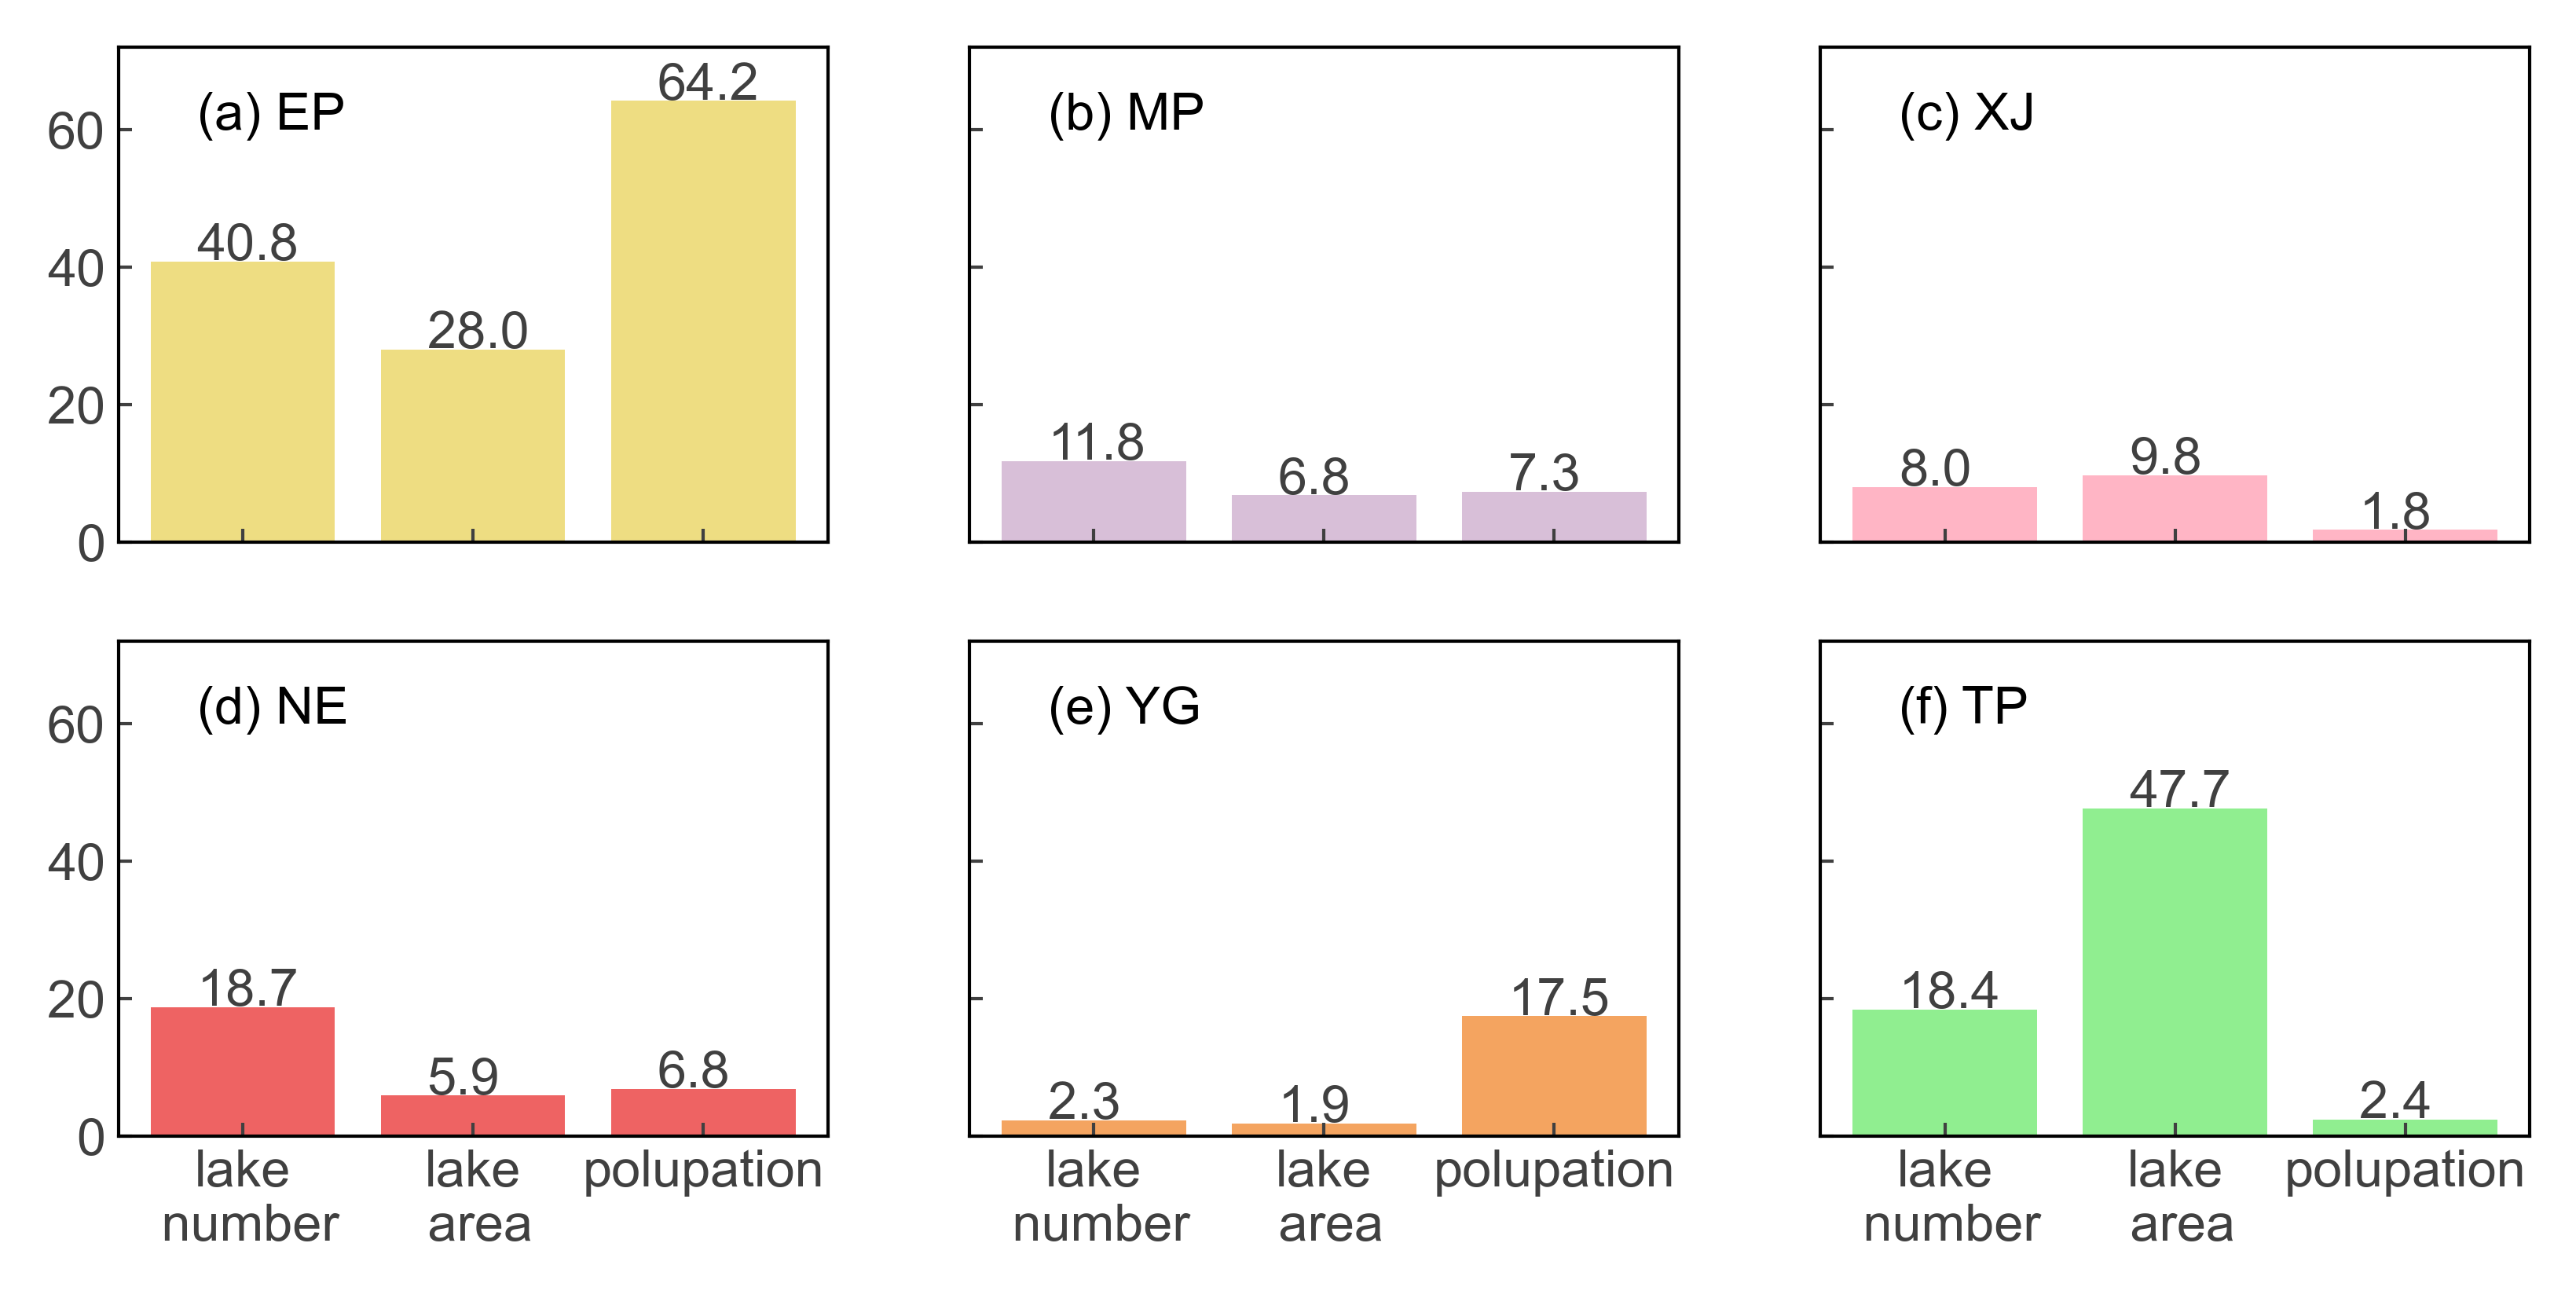

In [36]:
total_ln=len(lake_list[lake_list['2000']!=0])
total_la=lake_list['2000'].sum()
fig, axes = plt.subplots(2,3, figsize=(6.6,3), sharex=True, sharey=True, dpi=600)
for i, ax in enumerate(axes.ravel()):
    region_lake_list=lake_list[lake_list['Region']==regions[i]]
    lake_num_p=len(region_lake_list[region_lake_list['2000']!=0])/total_ln*100
    lake_area_p=region_lake_list['2000'].sum()/total_la*100
    population_p=population[population['Region']==regions[i]].iloc[0]['Percentage']

    ax.text(-0.2,60,'({}) {}'.format(chr(97+i),regions[i]))
    ax.bar(['lake\n number','lake\n area','polupation'],[lake_num_p,lake_area_p,population_p],color=colors[i])
    ax.text(-0.2,lake_num_p+0.2,'{:.1f}'.format(lake_num_p),color = "0.25")
    ax.text(0.8,lake_area_p+0.2,'{:.1f}'.format(lake_area_p),color = "0.25")
    ax.text(1.8,population_p+0.2,'{:.1f}'.format(population_p),color = "0.25")
    ax.set_ylim([0,72])
    ax.spines['bottom'].set_linewidth(lw[1])
    ax.spines['top'].set_linewidth(lw[1])#.set_visible(False)
    ax.spines['left'].set_linewidth(lw[1])
    ax.spines['right'].set_linewidth(lw[1])#.set_visible(False)
    ax.tick_params("both",which="major",
               length=lw[4],width = lw[1],
               colors = "0.25",labelsize=fs[0],pad=2)
plt.savefig(r'3_picture\2_lake_2000_regional_distribution.png',bbox_inches='tight',pad_inches = 0.1)

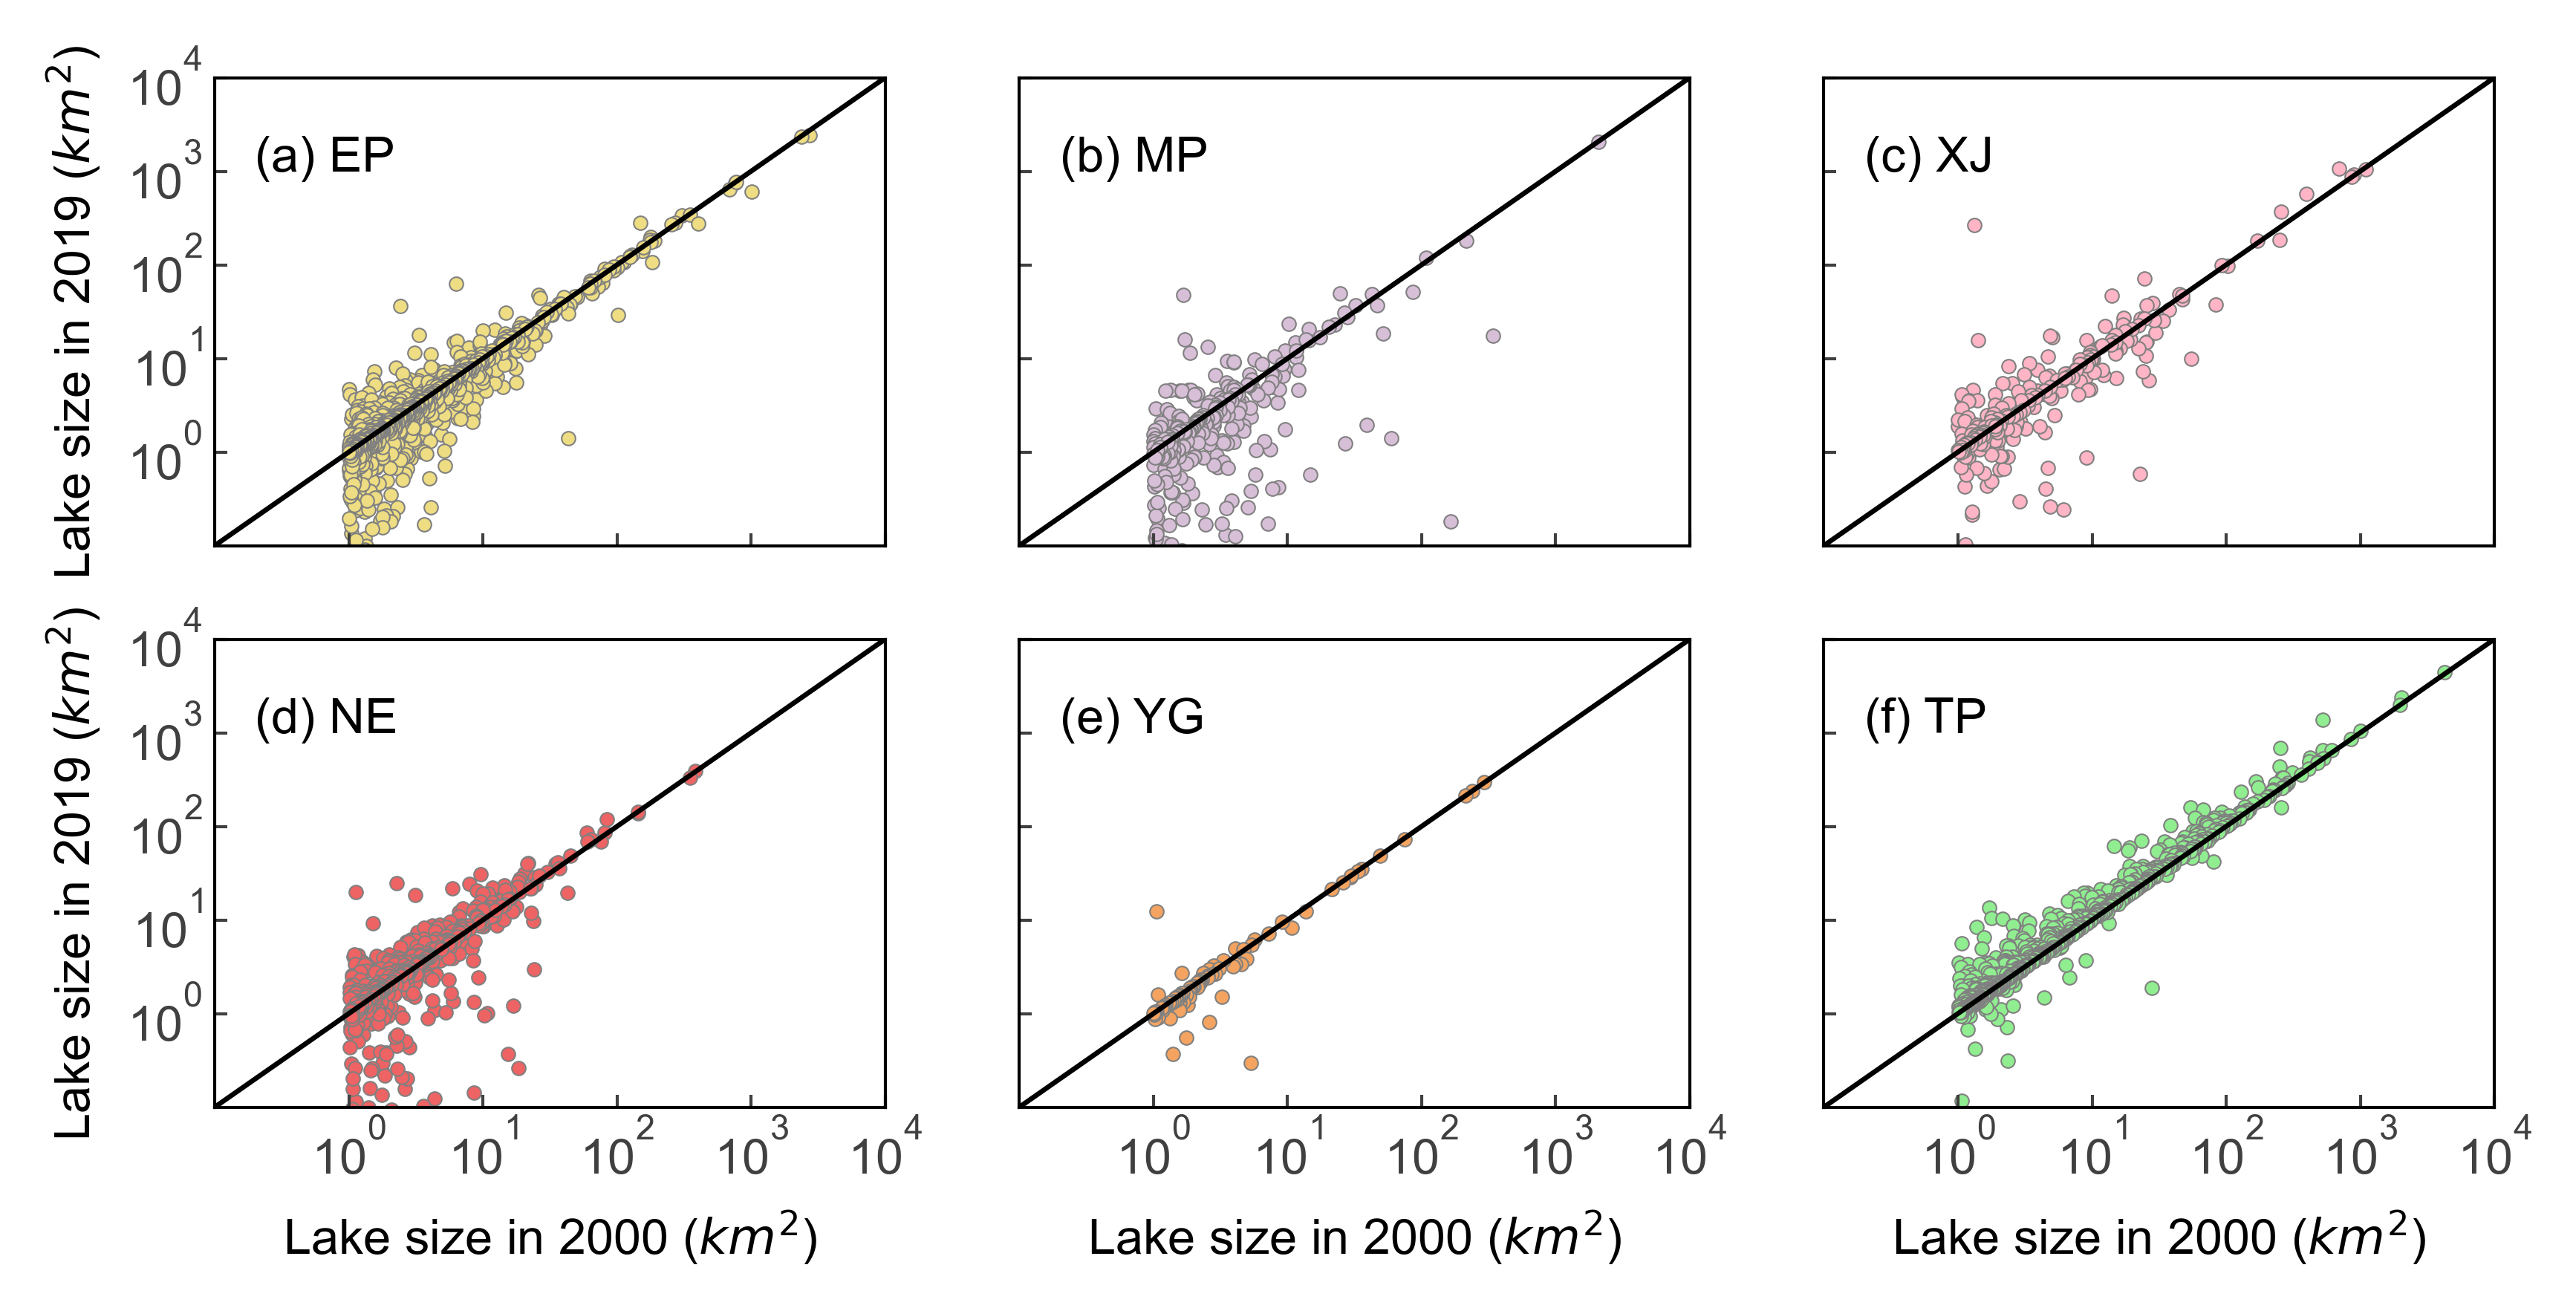

In [37]:
def draw_scatter(ax,color,marker,df,region,minSize,maxSize):
    subset=df[(df['Region']==region)&(df['2000']>=minSize)&(df['2000']<maxSize)]
    x=subset['2000'].tolist()
    y=subset['2019'].tolist()
    ax.scatter(x,y,s=5,c=color,linewidths=lw[0],marker=marker,edgecolors='gray',zorder=0)

ticks=[1,10,100,1000,10000]

fig, axes = plt.subplots(2,3, figsize=(6.6,3), sharex=True, sharey=True, dpi=600)
for i, ax in enumerate(axes.ravel()):
    draw_scatter(ax,colors[i],'o',lake_list,regions[i],1,10000)    
#     draw_scatter(ax,colors[i],'o',lake_list,regions[i],10,100)    
#     draw_scatter(ax,colors[i],'d',lake_list,regions[i],100,10000)  
    
    ax.spines['bottom'].set_linewidth(lw[1])
    ax.spines['top'].set_linewidth(lw[1])#.set_visible(False)
    ax.spines['left'].set_linewidth(lw[1])
    ax.spines['right'].set_linewidth(lw[1])#.set_visible(False)
    ax.tick_params("both",which="major",
               length=lw[4],width = lw[1],
               colors = "0.25",labelsize=fs[0],pad=2)
      
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlim([0.1,10000])
    ax.set_ylim([0.1,10000])
    ax.set_yticks(ticks)
    ax.set_xticks(ticks)
    ax.plot((0, 1), (0, 1), transform=ax.transAxes,c='k',linewidth=lw[2])
    ax.text(0.2,1000,'({}) {}'.format(chr(97+i),regions[i]))
    if i%3==0:
        ax.set_ylabel('Lake size in 2019 ($km^2$)')
    if i>=3:
        ax.set_xlabel('Lake size in 2000 ($km^2$)')
plt.savefig(r'3_picture\3_lake_2000_2019_changes.png',bbox_inches='tight',pad_inches = 0.1)        
    

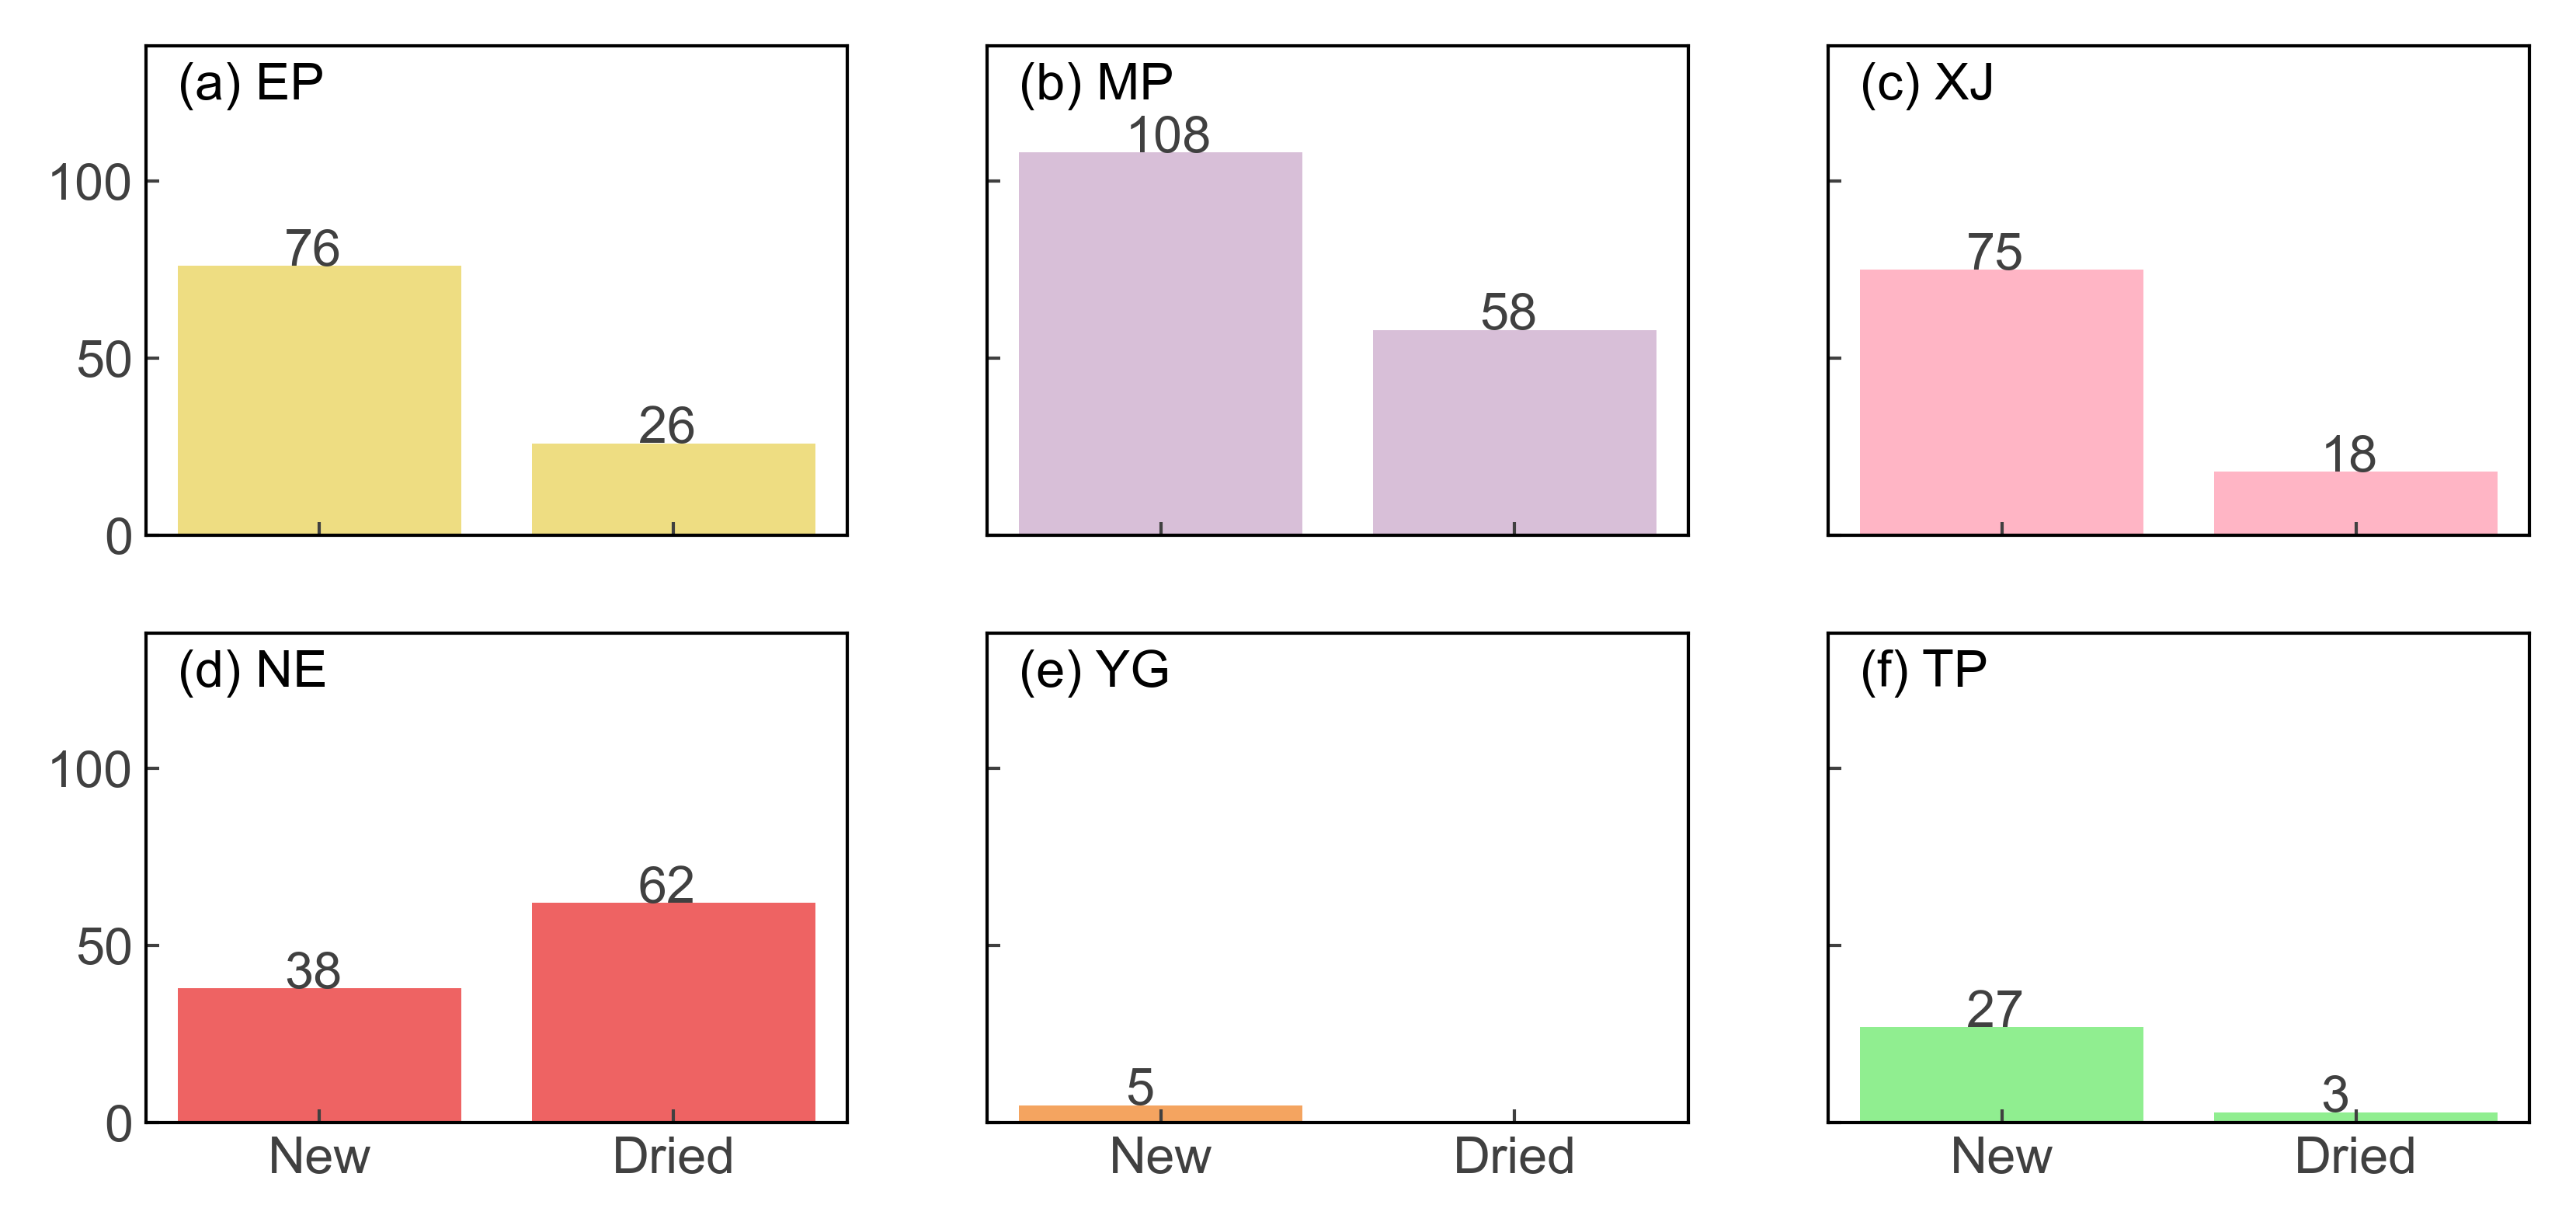

In [42]:
fig, axes = plt.subplots(2,3, figsize=(6.6,3), sharex=True, sharey=True, dpi=600)
for i, ax in enumerate(axes.ravel()):
    region_lake_list=lake_list[lake_list['Region']==regions[i]]
    new_lake_num=len(region_lake_list[(region_lake_list['2000']==0)&(region_lake_list['2019']!=0)])
    dry_lake_num=len(region_lake_list[(region_lake_list['2000']!=0)&(region_lake_list['2019']==0)])
    
    ax.text(-0.4,123,'({}) {}'.format(chr(97+i),regions[i]))
    ax.bar(['New','Dried'],[new_lake_num,dry_lake_num],color=colors[i])
    ax.set_ylim([0,138])
    ax.spines['bottom'].set_linewidth(lw[1])
    ax.spines['top'].set_linewidth(lw[1])#.set_visible(False)
    ax.spines['left'].set_linewidth(lw[1])
    ax.spines['right'].set_linewidth(lw[1])#.set_visible(False)
    ax.tick_params("both",which="major",
               length=lw[4],width = lw[1],
               colors = "0.25",labelsize=fs[0],pad=2)
    if new_lake_num!=0:
        ax.text(-0.1,new_lake_num+0.2,str(new_lake_num),color = "0.25")
    if dry_lake_num!=0:
        ax.text(0.9,dry_lake_num+0.2,str(dry_lake_num),color = "0.25")
plt.savefig(r'3_picture\4_new_and_dried_lakes.png',bbox_inches='tight',pad_inches = 0.1)        

## 4. calculate the RWA
the RWA of medium and large lakes(>10$km^2$) was calculated for each lake region during 10 periods using the following equation:
$$ RWA(\%)=1/n\sum_{i=1}^n(A_i/A_i^s)×100$$
where n,$A_i$ and $A_i^s$ represent the number of the medium and large lakes (>10 $km^2$), the area of the ith lake and the area of the $i$th lake in the base period, respectively.

In [44]:
columns=['Lake_id','Region']+['P{}'.format(i) for i in range(1,11)]
lake_change_list=pd.DataFrame(columns=columns)
index=0
for l_id in tqdm(lake.index):
    for r_id in six_region.index:
        region=six_region.loc[r_id]['geometry']
        region_name=six_region.loc[r_id]['name']
        if region.contains(lake.loc[l_id]['geometry'].centroid):
            lake_id=lake.loc[l_id]['Lake_id']
            lake_time_series=copy.copy(China_Lakes_time_series[China_Lakes_time_series['GLAKES_ID']==lake_id])
            
            if (lake_time_series.iloc[0]['Year']<2002) & (lake_time_series.iloc[0]['Area_dr']>10):
                As=lake_time_series.iloc[0]['Area_dr']
                lake_time_series['Ai']=lake_time_series['Area_dr']/As*100
                lake_change=[lake_id,region_name]
                #five period
                for i in np.arange(2000,2020,2):
                    period=lake_time_series[lake_time_series['Year'].map(lambda x: x>=i and x<i+2)]['Ai'].mean()
                    lake_change.append(period)
#                 print(lake_change)
                lake_change_list.loc[index]=lake_change
                index=index+1               
            break
lake_change_list.to_csv('lake_change_list.csv',index=False)
# lake_change_list

  0%|          | 0/6066 [00:00<?, ?it/s]

In [5]:
lake_change_list=pd.read_csv('lake_change_list.csv')
lake_change_list

,Lake_id,Region,P1,P2,P3,P4,P5,P6,P7,P8,P9,P10
0,46,TP,99.698534,99.301727,99.319921,99.898564,100.219669,100.819181,101.946947,102.098246,102.855247,104.106594
1,66,EP,92.717444,100.422466,86.516000,76.435522,73.192708,75.796868,90.186237,82.488876,93.124290,76.665485
2,83,EP,100.593019,101.295794,101.372479,101.179832,101.131355,99.655282,99.248367,100.104805,99.884008,99.363861
3,85,TP,101.191909,106.030152,108.834540,111.759978,113.492079,115.021635,116.294919,116.616468,116.291713,116.772871
4,99,MP,98.855470,98.520485,95.689815,92.792209,88.747624,85.632408,87.211276,97.536851,98.948380,98.210494
...,...,...,...,...,...,...,...,...,...,...,...,...
639,16229,EP,100.558497,101.166415,100.757757,101.097685,99.429978,98.065715,98.254306,98.394377,96.570301,96.157039
640,16265,EP,99.512754,100.108609,99.680402,98.966466,99.094455,98.573739,97.550841,97.968983,97.543243,96.879570
641,16738,XJ,100.412315,100.566005,101.069948,101.305551,101.991419,101.796244,103.169413,103.237161,104.266802,104.259556
642,16878,TP,101.029338,101.938287,101.911429,101.926074,101.861599,102.055096,101.943352,102.037042,102.058677,102.055096


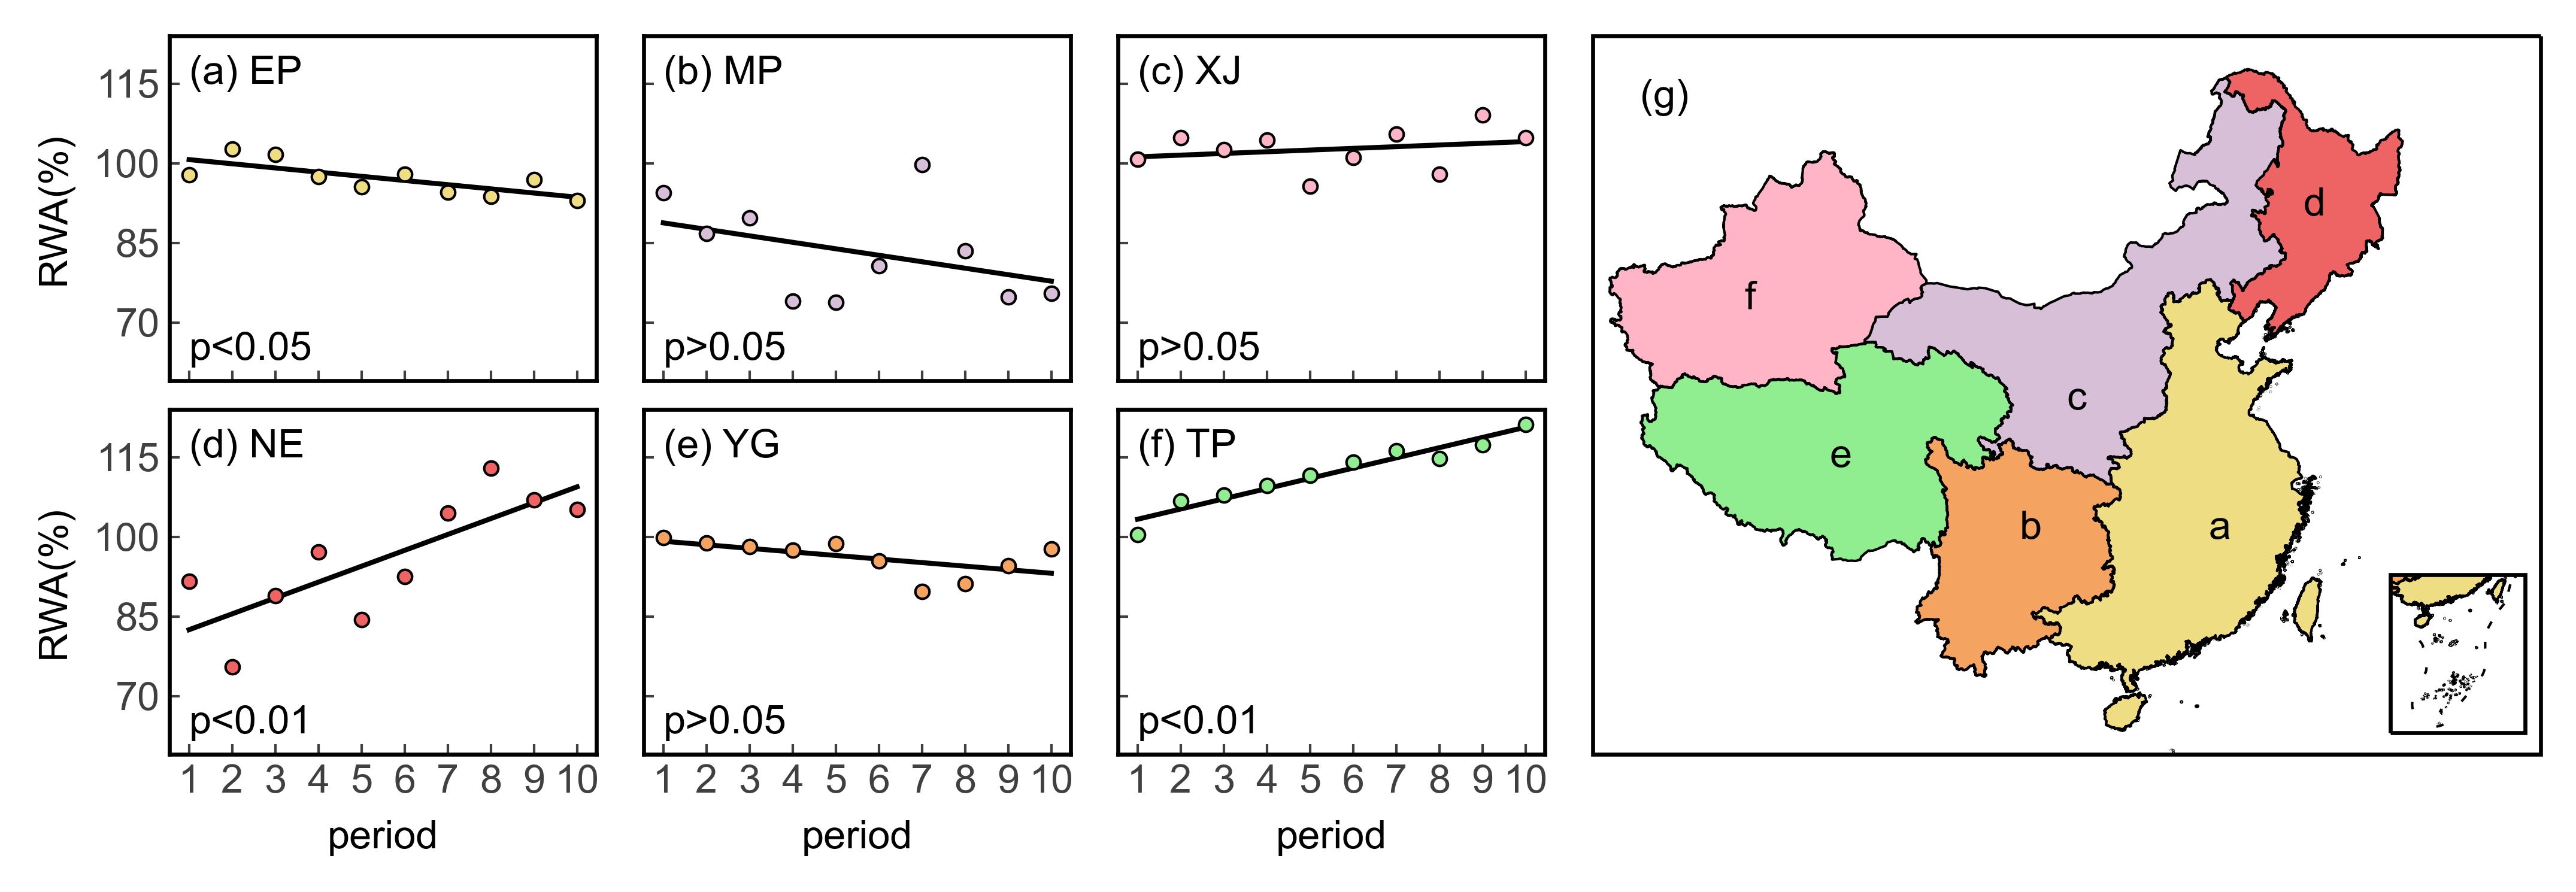

In [55]:
fig = plt.figure(figsize=(6.6,2), dpi=600)
ax1=fig.add_axes([0, 0.52, 0.18, 0.48])
ax2=fig.add_axes([0.2, 0.52, 0.18, 0.48])
ax3=fig.add_axes([0.4, 0.52, 0.18, 0.48])
ax4=fig.add_axes([0, 0, 0.18, 0.48])
ax5=fig.add_axes([0.2, 0, 0.18, 0.48])
ax6=fig.add_axes([0.4, 0, 0.18, 0.48])
ax7=fig.add_axes([0.6, 0, 0.4, 1],projection=proj)
ax7.set_extent([80, 133, 17, 54], crs=ccrs.PlateCarree())
ax8=fig.add_axes([0.87, 0.03, 0.19, 0.22],projection=ccrs.PlateCarree())
periods=range(1,11)
axes=[ax1,ax2,ax3,ax4,ax5,ax6]
for i, ax in enumerate(axes):
    
    change=lake_change_list[lake_change_list['Region']==regions[i]]
    meanRWA=change.iloc[:,2:12].mean()
#     std=change.iloc[:,2:12].std()
    ax.scatter(periods,meanRWA,s=8,c=colors[i],linewidths=lw[1],edgecolors='k',zorder=1)
    
    # 拟合线性模型
    period=np.array(periods).reshape((-1, 1))
    model = LinearRegression()
    model.fit(period, meanRWA)
    #进行预测
    meanRWA_bar = model.predict(period)
    ax.plot(periods,meanRWA_bar,'k',linewidth=lw[3],zorder=0)
    # 为特征矩阵添加常数列
    period_with_intercept = sm.add_constant(period)
    # 创建最小二乘模型
    model_ols = sm.OLS(meanRWA, period_with_intercept).fit()
    
    # p检验
    p=model_ols.pvalues.x1
    text='p>0.05'
    if p<0.01:
        text='p<0.01'
    elif p<0.05:
        text='p<0.05'
    ax.text(1,63,text)
    
    ax.spines['bottom'].set_linewidth(lw[2])
    ax.spines['top'].set_linewidth(lw[2])
    ax.spines['left'].set_linewidth(lw[2])
    ax.spines['right'].set_linewidth(lw[2])
    
    ax.tick_params("both",which="major",
               length=lw[4],width = lw[1],
               colors = "0.25",labelsize=fs[0],pad=2)
    if(i%3==0):
        ax.set_ylabel('RWA(%)')
    else:
        ax.yaxis.set_major_formatter(plt.NullFormatter())
        
    if i<3 :
        ax.xaxis.set_major_formatter(plt.NullFormatter())
    else:
        ax.set_xlabel('period')
#     ax.set_title(region_name)
    ax.text(1,115,'({}) {}'.format(chr(97+i),regions[i]))
    ax.set_ylim([59,124])
    ax.set_yticks([70,85,100,115])
    ax.set_xticks(periods)
    ax7.add_geometries(six_region[six_region['name']==regions[i]]['geometry'],crs=ccrs.PlateCarree(),facecolor=colors[i],edgecolor='black',linewidth=lw[1])
    ax8.add_geometries(six_region[six_region['name']==regions[i]]['geometry'],crs=ccrs.PlateCarree(),facecolor=colors[i],edgecolor='black',linewidth=lw[1])
    
ax7.add_geometries(southern_sea_island['geometry'],facecolor='white',edgecolor='black',linewidth=lw[1],crs=ccrs.PlateCarree())
ax7.spines['geo'].set_linewidth(lw[2])
draw_label(ax7,0.05,0.9,'(g)')
draw_label(ax7,0.65,0.3,'a')
draw_label(ax7,0.45,0.3,'b')
draw_label(ax7,0.5,0.48,'c')
draw_label(ax7,0.75,0.75,'d')
draw_label(ax7,0.25,0.4,'e')
draw_label(ax7,0.16,0.62,'f')

ax8.spines['geo'].set_linewidth(lw[2])
ax8.set_extent([105, 125, 2.5, 26],crs=ccrs.PlateCarree())
add_northern_sea(ax8)
plt.savefig(r'3_picture\5_Temporal_changes_in_lakes.png',bbox_inches='tight',pad_inches = 0.1)  

## 5.气候变化因素分析
### 5.1读取年降水、年蒸发、年均气温数据

In [56]:
#读取月降水、月蒸发、月均温数据
ds_list_p=[]
ds_list_e=[]
ds_list_t=[]
for year in range(2000,2020):
    ds=xr.open_dataset('2_climate_data/pre_{}.nc'.format(year), engine="netcdf4")
    ds_list_p.append(ds)
    ds=xr.open_dataset('2_climate_data/pet_{}.nc'.format(year), engine="netcdf4")
    ds_list_e.append(ds)
    ds=xr.open_dataset('2_climate_data/tmp_{}.nc'.format(year), engine="netcdf4")
    ds_list_t.append(ds)

In [59]:
#计算每一个中大型湖泊的年降水、年蒸发、年均气温
columns=['Lake_id','Region','lon','lat']+[i for i in range(2000,2020)]
lackdata_lake_list=[273,7158,8353,10955]
lake_pre_list=pd.DataFrame(columns=columns)
lake_pet_list=pd.DataFrame(columns=columns)
lake_tmp_list=pd.DataFrame(columns=columns)
lake_wa_list=pd.DataFrame(columns=columns)
index=0
for l_id in tqdm(lake_change_list.index):
    lake_id=lake_change_list.loc[l_id]['Lake_id']
    if lake_id in lackdata_lake_list:
        lon=lake[lake['Lake_id']==lake_id].iloc[0]['Lon']
        lat=lake[lake['Lake_id']==lake_id].iloc[0]['Lat']
        ls=[]
        for i in range(0,20):
            p=ds_list_p[i].pre.sel(lat=lat,lon=lon,method='nearest').sum()/10
            ls.append(p.item())
        print(ls)
        continue
    else:
        region_name=lake_change_list.loc[l_id]['Region']
        lon=lake[lake['Lake_id']==lake_id].iloc[0]['Lon']
        lat=lake[lake['Lake_id']==lake_id].iloc[0]['Lat']

        lake_pre=[lake_id,region_name,lon,lat]
        lake_pet=[lake_id,region_name,lon,lat]
        lake_wa=[lake_id,region_name,lon,lat]
        lake_tmp=[lake_id,region_name,lon,lat]

        for i in range(0,20):
            p=ds_list_p[i].pre.sel(lat=lat,lon=lon,method='nearest').sum()/10
            lake_pre.append(p.item()) 
            e=ds_list_e[i].etp.sel(lat=lat,lon=lon,method='nearest').sum()/10
            lake_pet.append(e.item()) 
            lake_wa.append(p.item()-e.item())
            t=ds_list_t[i].tmp.sel(lat=lat,lon=lon,method='nearest').mean()/10
            lake_tmp.append(t.item()) 
    #     print(lake_pet)
        lake_pre_list.loc[index]=lake_pre
        lake_pet_list.loc[index]=lake_pet
        lake_tmp_list.loc[index]=lake_tmp
        lake_wa_list.loc[index]=lake_wa
        index=index+1
lake_pre_list.to_csv('lake_pre_list.csv',index=False)
lake_pet_list.to_csv('lake_pet_list.csv',index=False)
lake_wa_list.to_csv('lake_wa_list.csv',index=False)
lake_tmp_list.to_csv('lake_tmp_list.csv',index=False)

  0%|          | 0/644 [00:00<?, ?it/s]

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 77.4, 79.5]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1060.0, 888.3]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1103.3, 944.3]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1094.9, 957.3]


In [6]:
pre_list=pd.read_csv('lake_pre_list.csv')
pre_list

,Lake_id,Region,lon,lat,2000,2001,2002,2003,2004,2005,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,46,TP,100.200635,36.886724,356.4,328.7,424.8,387.5,393.0,450.2,...,413.7,384.2,473.5,331.9,406.6,374.1,386.1,471.4,521.1,490.3
1,66,EP,116.280422,29.121175,1374.4,1346.4,1785.6,1428.8,1281.0,1447.7,...,1926.5,1124.8,1943.6,1286.7,1529.2,1922.7,1770.9,1452.3,1445.5,1544.4
2,83,EP,120.203463,31.200394,1105.6,1054.6,1191.4,916.1,898.9,927.9,...,1094.5,991.8,1102.6,914.0,1182.0,1267.6,1245.3,1141.0,1103.1,1113.7
3,85,TP,88.992953,31.800787,471.6,446.8,411.2,479.5,484.0,456.0,...,359.9,537.5,356.5,475.8,393.6,269.6,516.8,450.5,475.0,454.6
4,99,MP,117.398475,48.948009,211.2,176.6,216.9,215.4,161.8,201.7,...,228.4,210.5,257.3,364.3,229.6,190.3,227.3,207.6,285.8,233.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,16229,EP,120.554733,30.924880,979.6,967.3,1083.8,727.8,786.4,846.3,...,954.1,852.1,1030.0,787.4,1060.4,1126.8,1058.4,960.9,967.1,1039.7
636,16265,EP,113.113355,29.337219,1290.4,1139.3,1695.8,1199.0,1275.6,1231.8,...,1500.4,914.5,1512.4,1159.3,1221.0,1398.3,1447.2,1316.5,1225.4,1086.0
637,16738,XJ,78.568865,35.867830,10.3,10.6,11.7,20.7,17.0,16.9,...,20.6,17.0,13.7,18.5,8.1,12.4,4.9,15.0,13.5,13.1
638,16878,TP,82.478554,35.613035,18.5,18.0,15.3,40.5,22.8,23.4,...,33.3,14.0,36.0,22.3,22.2,19.9,15.7,26.3,23.7,27.9


In [7]:
pet_list=pd.read_csv('lake_pet_list.csv')
pet_list

,Lake_id,Region,lon,lat,2000,2001,2002,2003,2004,2005,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,46,TP,100.200635,36.886724,596.4,605.7,594.8,590.5,588.4,567.6,...,605.6,593.6,568.5,615.2,585.5,600.2,610.8,590.0,575.0,575.8
1,66,EP,116.280422,29.121175,1064.5,1068.5,1054.2,1106.0,1129.6,1072.3,...,1052.2,1072.1,1029.9,1122.9,1067.9,1026.2,1072.0,1103.9,1113.8,1110.7
2,83,EP,120.203463,31.200394,884.8,864.3,873.8,914.2,957.3,924.4,...,891.4,897.8,871.2,952.2,860.5,864.7,892.4,921.7,916.7,931.3
3,85,TP,88.992953,31.800787,571.7,587.4,594.4,581.3,587.1,585.2,...,646.4,589.8,611.6,598.0,596.2,623.1,612.5,610.3,593.4,602.7
4,99,MP,117.398475,48.948009,667.2,682.0,646.8,636.1,666.6,654.8,...,638.0,655.6,616.7,572.2,650.0,657.9,659.1,680.1,654.9,663.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,16229,EP,120.554733,30.924880,1053.7,1036.6,1043.7,1087.8,1121.6,1085.1,...,1059.0,1065.5,1039.9,1117.3,1041.7,1044.9,1061.2,1090.0,1082.0,1091.2
636,16265,EP,113.113355,29.337219,1081.6,1119.1,1077.6,1102.9,1138.9,1081.3,...,1067.7,1098.9,1046.2,1155.8,1069.3,1072.5,1095.6,1121.7,1143.2,1137.5
637,16738,XJ,78.568865,35.867830,573.5,577.6,570.0,540.5,578.3,545.7,...,557.2,570.2,549.5,575.5,549.4,555.2,571.9,557.6,557.0,548.1
638,16878,TP,82.478554,35.613035,466.9,474.1,463.3,446.6,479.4,457.8,...,459.1,469.0,453.5,476.4,447.2,451.9,476.0,462.2,452.4,457.0


In [8]:
wa_list=pd.read_csv('lake_wa_list.csv')
wa_list

,Lake_id,Region,lon,lat,2000,2001,2002,2003,2004,2005,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,46,TP,100.200635,36.886724,-240.0,-277.0,-170.0,-203.0,-195.4,-117.4,...,-191.9,-209.4,-95.0,-283.3,-178.9,-226.1,-224.7,-118.6,-53.9,-85.5
1,66,EP,116.280422,29.121175,309.9,277.9,731.4,322.8,151.4,375.4,...,874.3,52.7,913.7,163.8,461.3,896.5,698.9,348.4,331.7,433.7
2,83,EP,120.203463,31.200394,220.8,190.3,317.6,1.9,-58.4,3.5,...,203.1,94.0,231.4,-38.2,321.5,402.9,352.9,219.3,186.4,182.4
3,85,TP,88.992953,31.800787,-100.1,-140.6,-183.2,-101.8,-103.1,-129.2,...,-286.5,-52.3,-255.1,-122.2,-202.6,-353.5,-95.7,-159.8,-118.4,-148.1
4,99,MP,117.398475,48.948009,-456.0,-505.4,-429.9,-420.7,-504.8,-453.1,...,-409.6,-445.1,-359.4,-207.9,-420.4,-467.6,-431.8,-472.5,-369.1,-430.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,16229,EP,120.554733,30.924880,-74.1,-69.3,40.1,-360.0,-335.2,-238.8,...,-104.9,-213.4,-9.9,-329.9,18.7,81.9,-2.8,-129.1,-114.9,-51.5
636,16265,EP,113.113355,29.337219,208.8,20.2,618.2,96.1,136.7,150.5,...,432.7,-184.4,466.2,3.5,151.7,325.8,351.6,194.8,82.2,-51.5
637,16738,XJ,78.568865,35.867830,-563.2,-567.0,-558.3,-519.8,-561.3,-528.8,...,-536.6,-553.2,-535.8,-557.0,-541.3,-542.8,-567.0,-542.6,-543.5,-535.0
638,16878,TP,82.478554,35.613035,-448.4,-456.1,-448.0,-406.1,-456.6,-434.4,...,-425.8,-455.0,-417.5,-454.1,-425.0,-432.0,-460.3,-435.9,-428.7,-429.1


In [9]:
tmp_list=pd.read_csv('lake_tmp_list.csv')
tmp_list

,Lake_id,Region,lon,lat,2000,2001,2002,2003,2004,2005,...,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019
0,46,TP,100.200635,36.886724,-0.541667,-0.091667,-0.075000,0.083333,-0.241667,-0.316667,...,0.183333,-0.108333,-0.691667,0.025000,-0.016667,0.200000,0.466667,0.458333,-0.008333,0.183333
1,66,EP,116.280422,29.121175,18.075000,18.266667,18.541667,18.350000,18.466667,18.158333,...,18.025000,17.800000,17.758333,18.400000,18.050000,18.250000,18.683333,18.691667,18.658333,18.716667
2,83,EP,120.203463,31.200394,16.008333,16.108333,16.433333,16.016667,16.491667,15.958333,...,15.925000,15.741667,15.691667,16.291667,16.033333,16.266667,16.675000,16.725000,16.616667,16.725000
3,85,TP,88.992953,31.800787,-0.308333,0.216667,0.000000,0.233333,0.116667,0.458333,...,1.141667,0.325000,0.308333,0.375000,0.200000,0.100000,0.650000,0.725000,0.383333,0.350000
4,99,MP,117.398475,48.948009,-0.266667,-0.100000,0.791667,0.291667,0.825000,0.050000,...,-0.875000,0.058333,-0.933333,-0.350000,0.725000,1.216667,0.091667,0.925000,0.933333,1.133333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,16229,EP,120.554733,30.924880,16.300000,16.416667,16.750000,16.341667,16.800000,16.250000,...,16.233333,16.041667,15.991667,16.591667,16.383333,16.566667,17.008333,17.016667,16.958333,17.066667
636,16265,EP,113.113355,29.337219,17.641667,17.983333,18.116667,17.883333,18.183333,17.816667,...,17.716667,17.508333,17.341667,18.125000,17.741667,17.966667,18.325000,18.350000,18.316667,18.258333
637,16738,XJ,78.568865,35.867830,-4.066667,-3.891667,-4.141667,-4.625000,-3.833333,-4.683333,...,-3.858333,-3.916667,-4.625000,-3.950000,-4.600000,-4.033333,-3.383333,-3.983333,-3.958333,-4.325000
638,16878,TP,82.478554,35.613035,-8.008334,-7.641666,-7.958334,-8.125000,-7.516666,-8.150000,...,-7.600000,-7.766666,-8.325000,-7.775000,-8.550000,-7.883334,-7.258334,-7.666666,-8.058334,-8.091666


(5, 3)


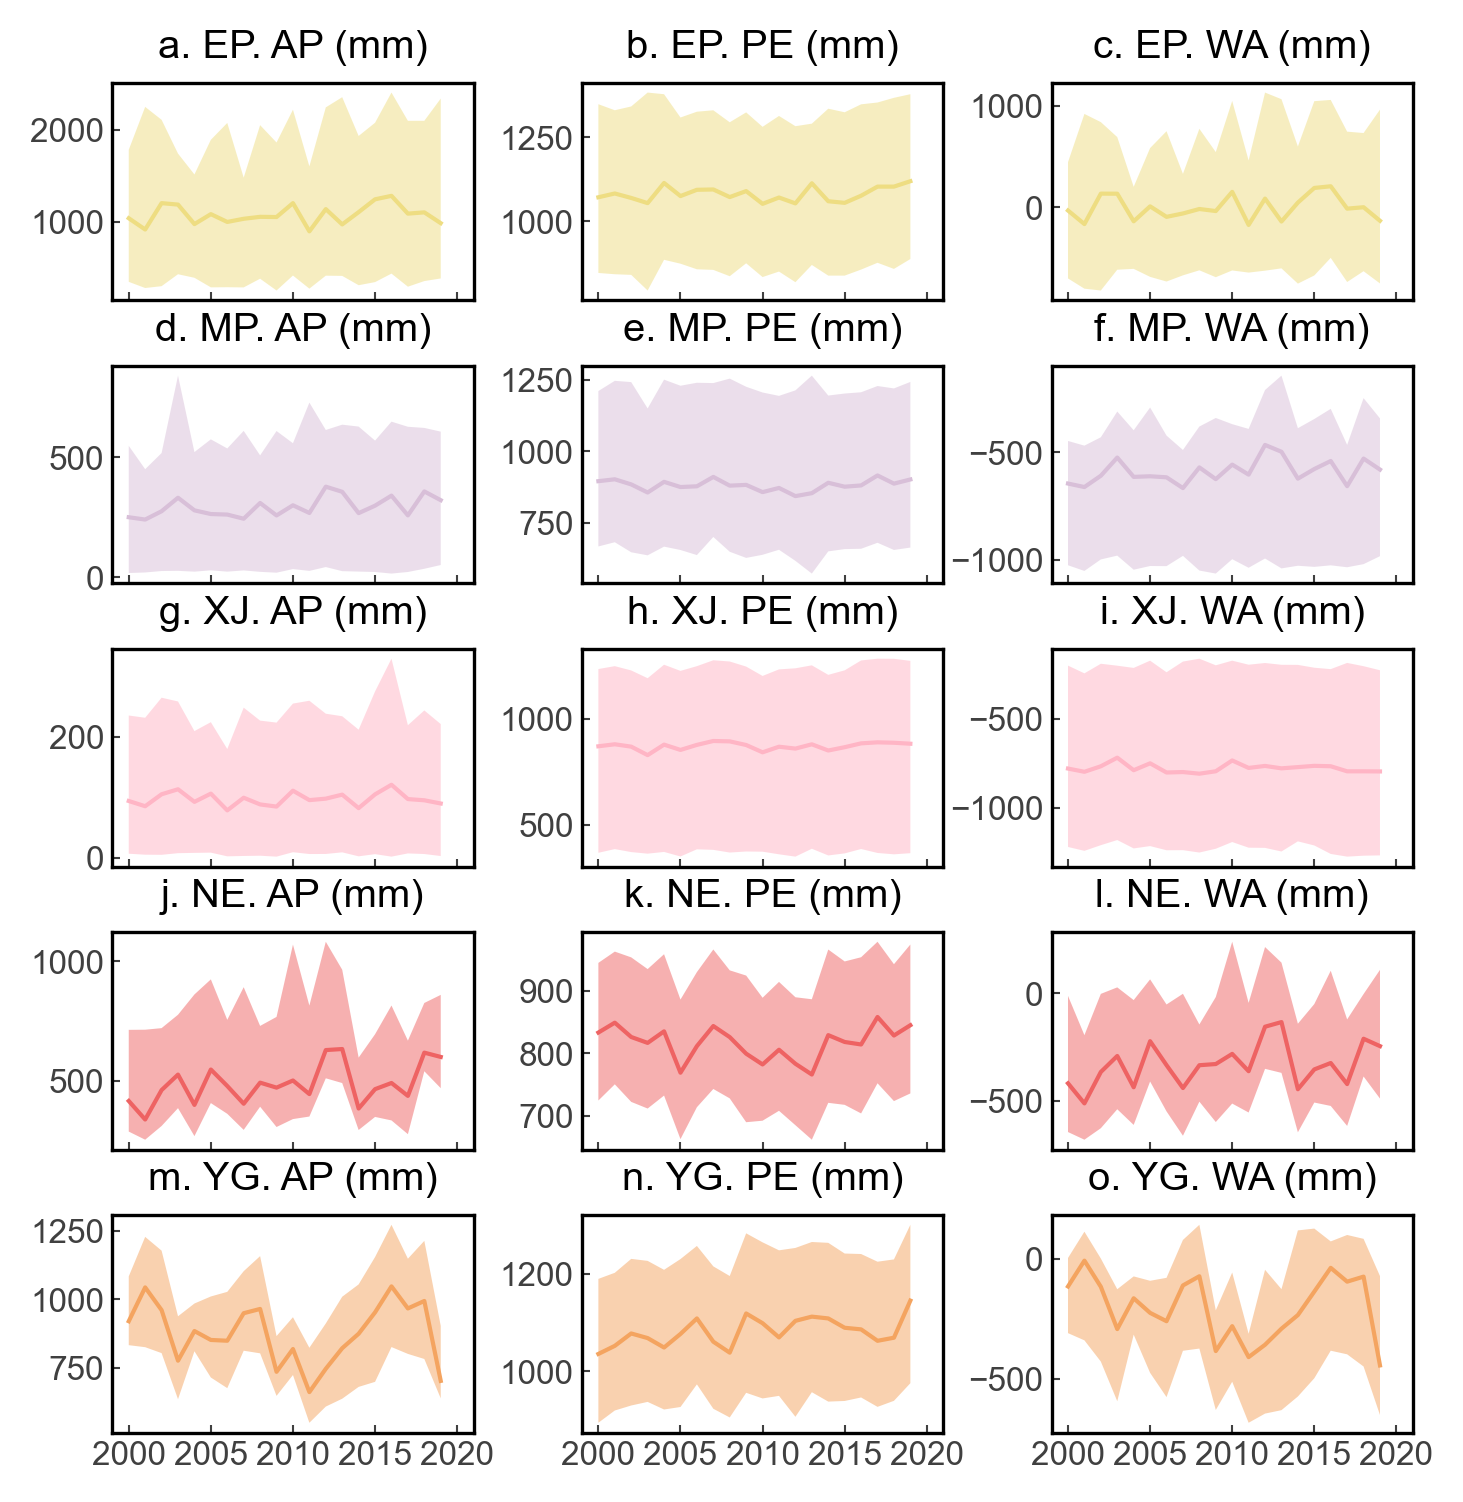

In [48]:
def draw_climate_data(ax,region,dataset,color,label):
    xtick=range(2000,2020)
    data=dataset[dataset['Region']==region]
    data=data.iloc[:,4:24]
    mean=data.mean().tolist()
    maxx=data.max().tolist()
    minn=data.min().tolist()
    ax.fill_between(xtick, minn, maxx,facecolor=color, alpha=0.50)
    ax.plot(xtick,mean,color,linewidth=lw[3])
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(lw[2])
    ax.spines['top'].set_linewidth(lw[2])
    ax.spines['left'].set_linewidth(lw[2])
    ax.spines['right'].set_linewidth(lw[2])
    
    ax.tick_params("both",which="major",
               length=lw[4],width = lw[1],
               colors = "0.25",labelsize=fs[0],pad=2)
    ax.set_title(label)
    ax.set_xticks(np.arange(2000,2021,5))
    ax.set_xlim(1999,2021)
    
fig, axes = plt.subplots(5,3, figsize=(5.1,5), sharex=True, sharey=False, dpi=300)
plt.subplots_adjust(left=0.1,bottom=0.05,right=0.95,top=0.95,wspace=0.3,hspace=0.3)
print(axes.shape)
sub_n=0
for i in range(5):
    draw_climate_data(axes[i][0],regions[i],pre_list,colors[i],'{}. {}. AP (mm)'.format(chr(97+sub_n),regions[i]))
    draw_climate_data(axes[i][1],regions[i],pet_list,colors[i],'{}. {}. PE (mm)'.format(chr(98+sub_n),regions[i]))
    draw_climate_data(axes[i][2],regions[i],wa_list,colors[i],'{}. {}. WA (mm)'.format(chr(99+sub_n),regions[i]))
    sub_n=sub_n+3
plt.savefig(r'3_picture\6_1_Changes_in_climatic_conditions_between_2000_2019.png',bbox_inches='tight',pad_inches = 0.1)  

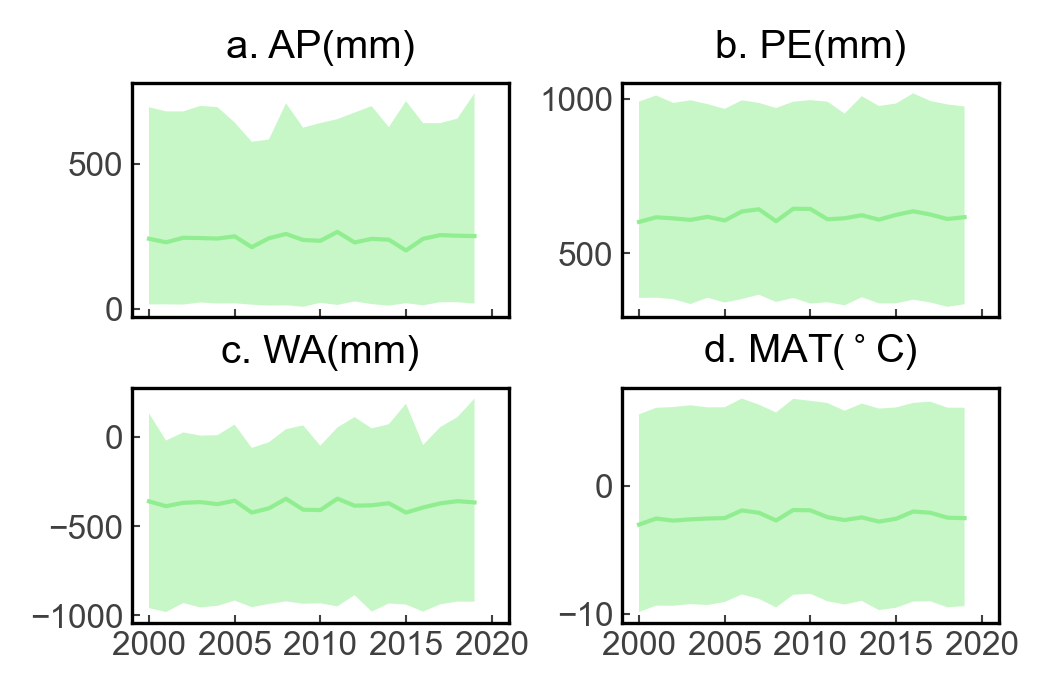

In [49]:
fig, axes = plt.subplots(2,2, figsize=(3.4,2), sharex=True, sharey=False, dpi=300)
plt.subplots_adjust(left=0.1,bottom=0.05,right=0.95,top=0.95,wspace=0.3,hspace=0.3)
draw_climate_data(axes[0,0],'TP',pre_list,colors[5],'a. AP(mm)')
draw_climate_data(axes[0,1],'TP',pet_list,colors[5],'b. PE(mm)')
draw_climate_data(axes[1,0],'TP',wa_list,colors[5],'c. WA(mm)')
draw_climate_data(axes[1,1],'TP',tmp_list,colors[5],'d. MAT($^\circ$C)')
plt.savefig(r'3_picture\6_2_Changes_in_climatic_conditions_between_2000_2019.png',bbox_inches='tight',pad_inches = 0.1)  

  0%|          | 0/640 [00:00<?, ?it/s]

C:\Users\lenovo\anaconda3\envs\ese5023\lib\site-packages\scipy\stats\stats.py:1603: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


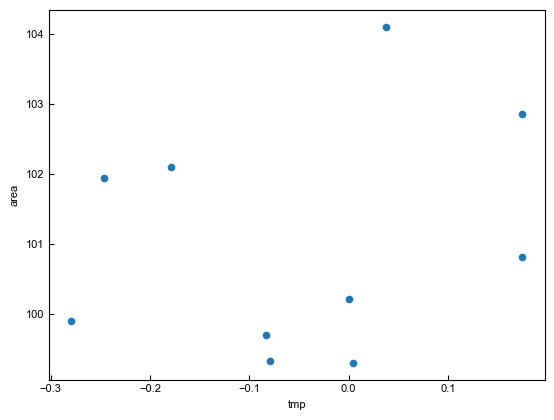

In [107]:
columns=['Lake_id','Region','r_squared','contribution_temp','contribution_wa','total_contribution']
contribution_list=pd.DataFrame(columns=columns)
# 拟合线性模型
for index in tqdm(lake_change_p_list.index):
    if index==0:
        columns=['period','area','wa','tmp']
        data_list=pd.DataFrame(columns=columns)
        valid_p=0
        for period in range(1,11):
            area=lake_change_p_list.iloc[index,1+period]
            if area==np.nan:
                continue
            else:
                wa=lake_wa_p_list.iloc[index,1+period]
                tmp=lake_tmp_p_list.iloc[index,1+period]
                data_list.loc[valid_p]=[period,area,wa,tmp]
                valid_p=valid_p+1
        model=ols('area~wa+tmp',data=data_list).fit()
        model.summary()
        anova_results = sm.stats.anova_lm(model, typ=2)
    #     print(anova_results)
        # 计算R^2值
        r_squared = model.rsquared
        # 获取回归系数
        beta_temp = model.params['tmp']
        beta_wa = model.params['wa']
        # 计算各自变量的贡献度
        contribution_temp = (beta_temp**2 / r_squared) * 100
        contribution_wa = (beta_wa**2 / r_squared) * 100
        Lake_id=lake_change_p_list.iloc[index,0]
        Region=lake_change_p_list.iloc[index,1]
        contribution_list.loc[index]=[Lake_id,Region,r_squared,contribution_temp,contribution_wa,contribution_temp+contribution_wa]
#     print(contribution_list.iloc[index])
        # 打印结果
#         print("tmp: {:.2f}%".format(contribution_temp))
#         print("wa: {:.2f}%".format(contribution_wa))
        data_list.plot.scatter(x='tmp',y='area')
#         x=sm.add_constant(data_list.iloc[:,2:])
#         y=data_list['area']
#         print(X)
#         model = sm.OLS(y, x) #生成模型
#         result = model.fit() #模型拟合
#         result.summary() #模型描述
#         #进行预测
#         area_bar = model.predict(x)
#         xtick=valid_p.period.tolist()
# #         print(area_bar)
#         ax.plot(xtick,area_bar,'k',linewidth=lw[3],zorder=0)
#         ax.plot(xtick,valid_p.area,'blue',linewidth=lw[3],zorder=0)
        # 为特征矩阵添加常数列
#         x_with_intercept = sm.add_constant(x)
#         # 创建最小二乘模型
#         model_ols = sm.OLS(area_list, X_with_intercept).fit()
#         print(model_ols.summary())
    

In [4]:
CLT=pd.read_csv(r'1_data\lake area time series_2000-2019_China.csv')
CLT

,GLAKES_ID,Year,Reservoir_flag,Area_raw,Area_dr
0,44,2000,0,151.452703,1211.170476
1,44,2001,0,1030.693554,1210.341072
2,44,2002,0,472.115406,1210.310305
3,44,2003,0,1212.516327,1214.170653
4,44,2004,0,1207.558202,1212.641128
...,...,...,...,...,...
143575,192203,2015,0,0.978261,0.979147
143576,192203,2016,0,0.956111,0.956259
143577,192203,2017,0,0.931747,0.931747
143578,192203,2018,0,0.915504,0.915947


In [117]:
def draw(ax,data,label):
    xtick=range(2000,2020)
    ax.plot(xtick,data.tolist(),linewidth=lw[3],label=label)
    ax.set_ylabel(label,fontsize=fs[0])
    ax.set_xticks([])
    ax.set_xlim(1999,2021)
    ax.tick_params("both",which="major",
               length=lw[4],width = lw[1],
               colors = "0.25",labelsize=fs[0],pad=2)
columns=['Lake_id','Region','r_squared']
contribution_list=pd.DataFrame(columns=columns)
# 拟合线性模型
for index in tqdm(tmp_list.index):
#     if index==20:
    Lake_id=tmp_list.iloc[index,0]
    Region=tmp_list.iloc[index,1]
    area_list=CLT[CLT==Lake_id]
    columns=['year','area','pre','pet','wa','tmp']
    data_list=pd.DataFrame(columns=columns)
    valid_p=0
    for year in range(2000,2020):
        area=CLT.query('GLAKES_ID =={} and Year =={}'.format(Lake_id,year)).iloc[0]['Area_dr']
#         area = China_Lakes_time_series.iloc[i]
        if (area==np.nan) or (area==0):
#             print(area)
            continue
        else:
            wa=wa_list.iloc[index,year-1996]
            pre=pre_list.iloc[index,year-1996]
            pet=pet_list.iloc[index,year-1996]
            tmp=tmp_list.iloc[index,year-1996]
            data_list.loc[valid_p]=[year,area,pre,pet,wa,tmp]
            valid_p=valid_p+1
        data_list=data_list.dropna()
    if data_list.year.count()==20:
        model=ols('area~pre+pet+tmp',data=data_list).fit()
    #         model.summary()
        # 计算R^2值
        r_squared = model.rsquared
        contribution_list.loc[index]=[Lake_id,Region,r_squared]
        if r_squared>0.5:
            fig = plt.figure(figsize=(2,4),dpi=300)
            plt.subplots_adjust(left=0.1,bottom=0.05,right=0.95,top=0.95,wspace=0.3,hspace=0.3)
    #             fig, axes = plt.subplots(5,1, figsize=(2.5,6), sharex=True, sharey=False, dpi=300)
            anova_results = sm.stats.anova_lm(model, typ=2)
    #             print(anova_results)
            draw(plt.subplot2grid((5,1), (0,0)),data_list['pre'],'AP(mm)')
            draw(plt.subplot2grid((5,1), (1,0)),data_list['pet'],'PE(mm)')
            draw(plt.subplot2grid((5,1), (2,0)),data_list['tmp'],'temperature($^\circ$C)')')
            ax=plt.subplot2grid((5,1), (3,0))
            area_bar = model.predict(data_list)
    # #             print(area_bar)
            xtick=range(2000,2020)
            ax.plot(xtick,area_bar.tolist(),'b--',linewidth=lw[3],label='prediction')
            ax.plot(xtick,data_list['area'].tolist(),'k',linewidth=lw[3],label='area')
    #             axes[3].legend()
            ax.set_ylabel('area($km^2$)',fontsize=fs[0])
            ax.set_xticks(np.arange(2000,2021,4))
            ax.set_xlim(1999,2021)
            ax.tick_params("both",which="major",
               length=lw[4],width = lw[1],
               colors = "0.25",labelsize=fs[0],pad=2)

            ax5=plt.subplot2grid((5,1), (4,0))
            ax5.axis("tight")
            ax5.axis("off")
            ax5.table(cellText=anova_results.iloc[0:3,2:4].values, colLabels=['F','P'], rowLabels=["pre", "pet", "tmp"], loc='best',fontsize=fs[1])
    #             ax5.table(cellText=anova_results.values, colLabels=anova_results.columns, rowLabels=["pre", "pet", "tmp","Resual"], loc='best',fontsize=fs[1])
            plt.suptitle('id={} $R^2$={:.2f}'.format(Lake_id,r_squared),fontsize=fs[0])
            plt.savefig(r'3_picture\{}_lake_{}.png'.format(Region,Lake_id),bbox_inches='tight',pad_inches = 0.02)  
            plt.close()

  0%|          | 0/640 [00:00<?, ?it/s]

Text(0, 0.5, 'percent of medium and large lakes (%)')

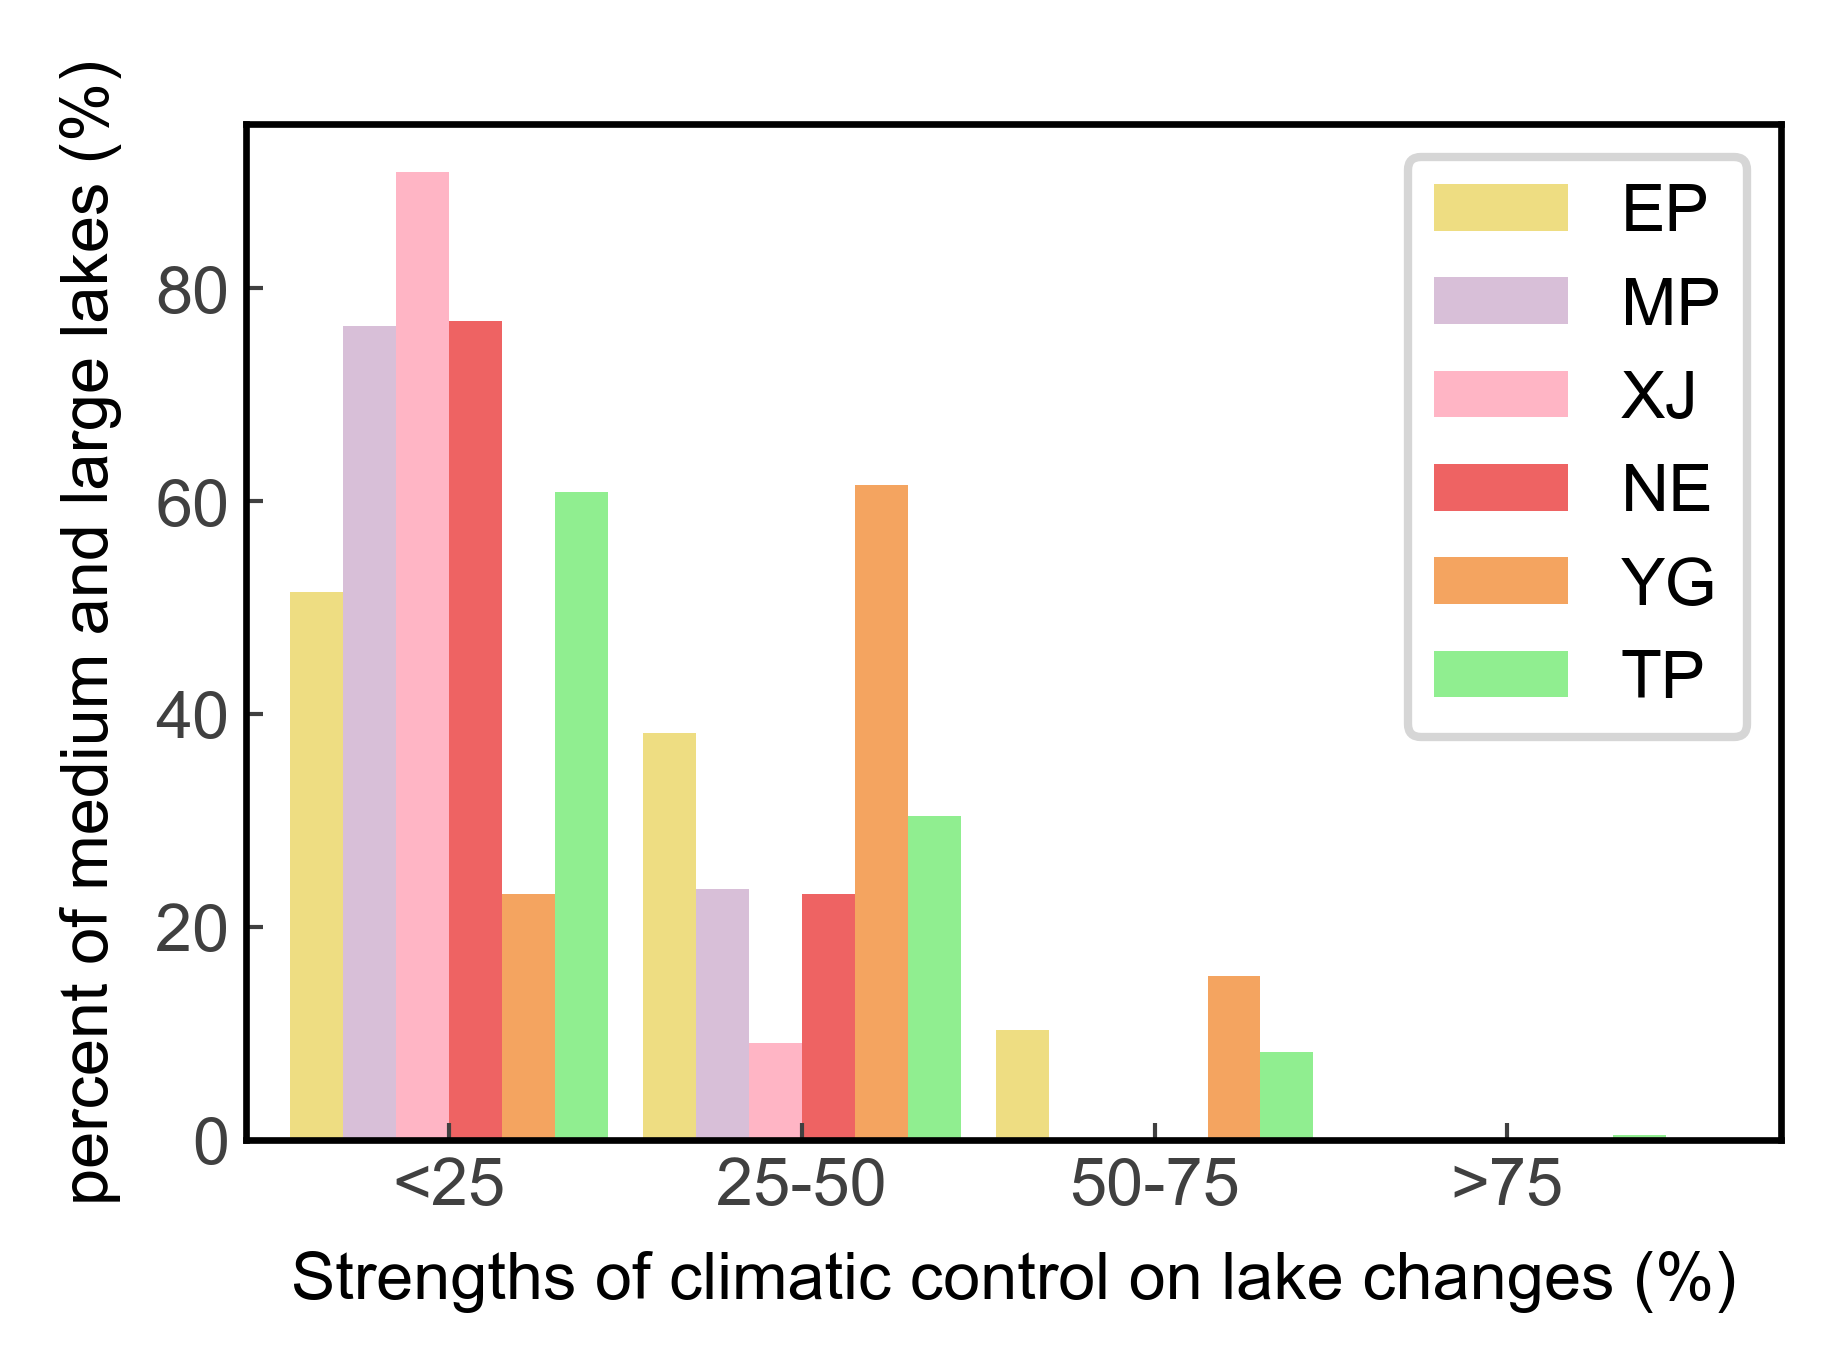

In [119]:

fig,ax= plt.subplots(1,1,figsize=(3.3,2.2), dpi=600) #inchr2List=[]
for i in range(6):
    region= regions[i]
#     print(region)
    sumcount=contribution_list.query("Region =='{}'".format(region)).r_squared.count()
#     print(sumcount)
    r25=contribution_list.query("Region =='{}' and r_squared >{} and r_squared <={}".format(region,0,0.25)).r_squared.count()/sumcount*100
#     print(r25)
    r50=contribution_list.query("Region =='{}' and r_squared >{} and r_squared <={}".format(region,0.25,0.50)).r_squared.count()/sumcount*100
    r75=contribution_list.query("Region =='{}' and r_squared >{} and r_squared <={}".format(region,0.5,0.75)).r_squared.count()/sumcount*100
    r100=contribution_list.query("Region =='{}' and r_squared >{} and r_squared <={}".format(region,0.75,1)).r_squared.count()/sumcount*100
    plt.bar(np.arange(0,4)+i*0.15,[r25,r50,r75,r100],width=0.15,color=colors[i],label=region)
plt.xticks([0.375,1.375,2.375,3.375],['<25','25-50','50-75','>75'])
ax.set_xlim(-0.2,4.15)
ax.tick_params("both",which="major",
               length=lw[4],width = lw[1],
               colors = "0.25",labelsize=fs[0],pad=2)
ax.legend(fontsize=fs[0])
ax.set_xlabel('Strengths of climatic control on lake changes (%)',fontsize=fs[0])
ax.set_ylabel('percent of medium and large lakes (%)',fontsize=fs[0])